<a href="https://colab.research.google.com/github/assaabriiii/AI/blob/main/MLP_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

SIZE = (12, 12)        # image resize
NOISE_LEVEL = 0.10     # fraction of pixels flipped for capacity test and recall visuals
MSE_EPOCHS = 80
LR = 0.03
MAX_ITER = 100
RANDOM_SEED = 42
SAVE_FIGS = False      # set True to save plots to ./results/
RESULTS_DIR = Path('./results')
RESULTS_DIR.mkdir(exist_ok=True)

np.random.seed(RANDOM_SEED)

farsi_dir = 'farsi'
english_dir = 'english'

In [31]:
def load_digit_patterns(folder_path):
    folder = Path(folder_path)
    if not folder.exists():
        raise FileNotFoundError(f"Folder not found: {folder_path}")
    patterns = []
    for fname in sorted(folder.iterdir()):
        if fname.suffix.lower() == '.png':
            p = load_and_preprocess_image(fname)
            if p is not None:
                patterns.append(p)
    if len(patterns) == 0:
        raise ValueError(f"No PNG patterns found in {folder_path}")
    return np.array(patterns)


def create_weight_matrix(patterns):
    n = patterns.shape[1]
    W = np.zeros((n,n), dtype=float)
    for p in patterns:
        W += np.outer(p,p)
    np.fill_diagonal(W, 0)
    return W / patterns.shape[0]


def add_noise(pattern, noise_level=NOISE_LEVEL):
    noisy = pattern.copy()
    k = int(noise_level * len(pattern))
    if k <= 0:
        return noisy
    idx = np.random.choice(len(pattern), k, replace=False)
    noisy[idx] *= -1
    return noisy


def synchronous_recall_with_energy(pattern, W, max_iter=MAX_ITER):
    s = pattern.copy()
    energies = [hopfield_energy(s, W)]
    for it in range(max_iter):
        new_s = np.sign(W @ s)
        new_s[new_s==0] = 1
        energies.append(hopfield_energy(new_s, W))
        if np.array_equal(new_s, s):
            s = new_s
            break
        s = new_s
    return s, energies


def asynchronous_recall_with_energy(pattern, W, max_iter=MAX_ITER):
    s = pattern.copy()
    energies = [hopfield_energy(s, W)]
    n = len(s)
    for it in range(max_iter):
        prev = s.copy()
        order = np.random.permutation(n)
        for i in order:
            h = W[i] @ s
            s[i] = 1 if h >= 0 else -1
        energies.append(hopfield_energy(s, W))
        if np.array_equal(s, prev):
            break
    return s, energies


def load_and_preprocess_image(filepath, size=SIZE):
    img = cv2.imread(str(filepath), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img_r = cv2.resize(img, size)
    _, binary = cv2.threshold(img_r, 128, 1, cv2.THRESH_BINARY)
    return np.where(binary.flatten() == 0, -1, 1)

def hopfield_energy(state, W):
    return -0.5 * state.T @ W @ state


def plot_results(original, noisy, sync_rec, async_rec):
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))

    images = [original, noisy, sync_rec, async_rec]
    titles = ["Original", "Noisy (10%)", "Recovered (Sync)", "Recovered (Async)"]

    for i, ax in enumerate(axes):
        img = images[i].reshape(SIZE)
        ax.imshow(img, cmap='gray')
        ax.set_title(titles[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [21]:
try:
    farsi_patterns = load_digit_patterns(farsi_dir)
    english_patterns = load_digit_patterns(english_dir)
    all_patterns = np.concatenate((farsi_patterns, english_patterns), axis=0)
except Exception as e:
    print(f"Error loading data: {e}")
    all_patterns = np.sign(np.random.randn(20, 144))


In [23]:
W = create_weight_matrix(all_patterns)

In [25]:
target_pattern = all_patterns[0]
noisy_pattern = add_noise(target_pattern, noise_level=0.10)

In [28]:
rec_sync, energy_sync = synchronous_recall_with_energy(noisy_pattern, W)

In [30]:
rec_async, energy_async = asynchronous_recall_with_energy(noisy_pattern, W)

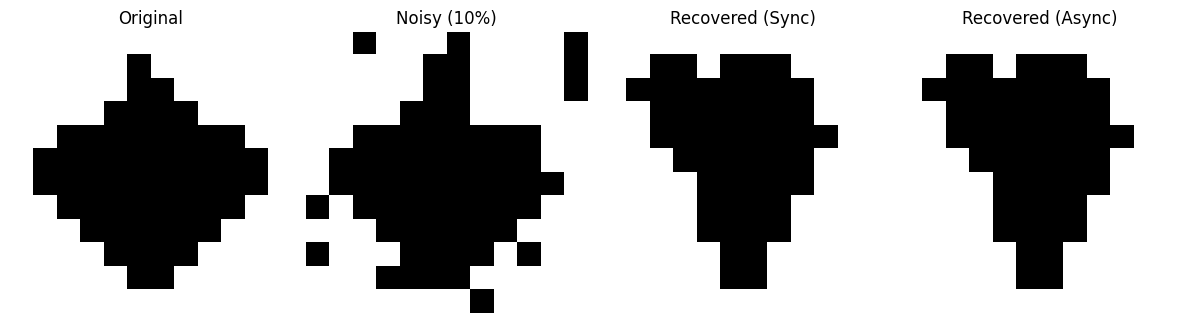

Synchronous Recovery Successful: False
Asynchronous Recovery Successful: False


In [33]:
plot_results(target_pattern, noisy_pattern, rec_sync, rec_async)

is_sync_correct = np.array_equal(target_pattern, rec_sync)
is_async_correct = np.array_equal(target_pattern, rec_async)

print(f"Synchronous Recovery Successful: {is_sync_correct}")
print(f"Asynchronous Recovery Successful: {is_async_correct}")

In [35]:
def plot_energy_comparison(energy_sync, energy_async):
    plt.figure(figsize=(10, 6))

    plt.plot(energy_sync, 'o-', label='Synchronous Update', linewidth=2, color='blue')

    plt.plot(energy_async, 's--', label='Asynchronous Update', linewidth=2, color='red')

    plt.xlabel('Iteration Steps')
    plt.ylabel('Network Energy (E)')
    plt.title('Energy Minimization Process (Hopfield Network)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    print(f"Initial Energy (Noisy): {energy_sync[0]:.2f}")
    print(f"Final Energy (Sync): {energy_sync[-1]:.2f}")
    print(f"Final Energy (Async): {energy_async[-1]:.2f}")

    plt.show()


Plotting Energy Dynamics...
Initial Energy (Noisy): -632.20
Final Energy (Sync): -1643.00
Final Energy (Async): -1643.00


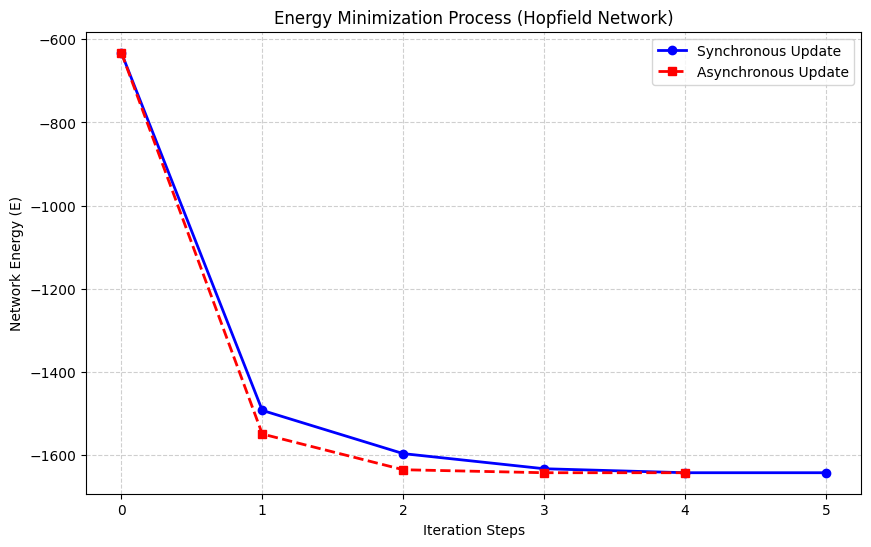

1. Energy Reduction: Yes. The network successfully minimized its energy.
2. Synchronous Oscillation detected: False
3. Stability: Both methods reached a stable state (Energy flatline).
   Converged in 5 steps for Sync and 4 steps for Async.


In [38]:
print("\nPlotting Energy Dynamics...")
plot_energy_comparison(energy_sync, energy_async)


if energy_async[-1] < energy_async[0]:
    print("1. Energy Reduction: Yes. The network successfully minimized its energy.")
else:
    print("1. Energy Reduction: No. Energy did not decrease (Unusual).")

is_oscillating = False
if len(energy_sync) > 2:
    if energy_sync[-1] != energy_sync[-2]:
         is_oscillating = True
print(f"2. Synchronous Oscillation detected: {is_oscillating}")
if is_oscillating:
    print("   (Sync updates can sometimes oscillate between two states instead of settling.)")

print(f"3. Stability: Both methods reached a stable state (Energy flatline).")
print(f"   Converged in {len(energy_sync)-1} steps for Sync and {len(energy_async)-1} steps for Async.")

In [45]:
def train_weights_modified(patterns, rule='mae', epochs=MSE_EPOCHS, lr=LR):
    P, N = patterns.shape
    W = create_weight_matrix(patterns)
    for ep in range(epochs):
        for p in patterns:
            h = W @ p
            y = np.tanh(h)
            diff = p - y
            if rule.lower() == 'mae':
                grad_factor = np.sign(diff)
            else:
                # default mse
                grad_factor = diff
            dW = lr * np.outer(grad_factor, p)
            W += dW
        np.fill_diagonal(W, 0)
    return W



def show_row_grid(originals, noisies, recovereds, title_prefix, size=SIZE, save=None):
    k = len(originals)
    rows, cols = 3, k
    fig, axs = plt.subplots(rows, cols, figsize=(cols*1.6, rows*1.6))
    if cols == 1:
        axs = axs.reshape(rows, 1)
    for c in range(cols):
        axs[0, c].imshow((originals[c].reshape(size) == 1).astype(int), cmap='gray')
        axs[0, c].axis('off')
        axs[1, c].imshow((noisies[c].reshape(size) == 1).astype(int), cmap='gray')
        axs[1, c].axis('off')
        axs[2, c].imshow((recovereds[c].reshape(size) == 1).astype(int), cmap='gray')
        axs[2, c].axis('off')
    plt.suptitle(title_prefix)
    plt.tight_layout(rect=[0,0.03,1,0.95])
    if save:
        plt.savefig(save, bbox_inches='tight')
    plt.show()


def overlay_energy_plot(energy_histories, title, save=None):
    plt.figure(figsize=(8,4))
    maxlen = max(len(h) for h in energy_histories)
    for i, h in enumerate(energy_histories):
        padded = list(h) + [h[-1]]*(maxlen - len(h))
        plt.plot(range(len(padded)), padded, label=f'pattern {i}')
    plt.xlabel('Iteration')
    plt.ylabel('Hopfield Energy')
    plt.title(title)
    plt.legend(fontsize=8, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    if save:
        plt.savefig(save, bbox_inches='tight')
    plt.show()


def experiment_analysis(patterns, dataset_name, rule='classic', strategy='asynchronous', noise_level=NOISE_LEVEL, mae_default=True, save_figs=SAVE_FIGS):
    P = patterns.shape[0]
    print(f"\n=== {dataset_name} | rule={rule} | strategy={strategy} ===")
    for k in range(1, P+1):
        subset = patterns[:k]
        if rule == 'classic':
            W = create_weight_matrix(subset)
        else:
            train_rule = 'mae' if mae_default else 'mse'
            W = train_weights_modified(subset, rule=train_rule, epochs=MSE_EPOCHS, lr=LR)

        originals = []
        noisies = []
        recovereds = []
        energy_histories = []
        correct = 0

        for i in range(k):
            orig = subset[i]
            noisy = add_noise(orig, noise_level)
            if strategy == 'synchronous':
                rec, energies = synchronous_recall_with_energy(noisy, W)
            else:
                rec, energies = asynchronous_recall_with_energy(noisy, W)

            originals.append(orig)
            noisies.append(noisy)
            recovereds.append(rec)
            energy_histories.append(energies)
            if np.array_equal(rec, orig):
                correct += 1

        acc = correct / k * 100
        title_prefix = f"{dataset_name} | {rule} | {strategy} | k={k} | acc={acc:.1f}%"

        # show three-row grid
        save_img = None
        if save_figs:
            save_img = RESULTS_DIR / f"{dataset_name}_{rule}_{strategy}_k{k}_grid.png"
        show_row_grid(originals, noisies, recovereds, title_prefix, size=SIZE, save=save_img)

        # overlay energy plot
        save_energy = None
        if save_figs:
            save_energy = RESULTS_DIR / f"{dataset_name}_{rule}_{strategy}_k{k}_energy.png"
        overlay_energy_plot(energy_histories, title_prefix + " - Energy Traces", save=save_energy)

        print(f"Stored {k} patterns -> accuracy (noisy->original): {acc:.1f}%")


def capacity_analysis(patterns, dataset_name, rule='classic', strategy='asynchronous', noise_level=NOISE_LEVEL, mae_default=True, save_figs=SAVE_FIGS):
    P = patterns.shape[0]
    accuracies = []
    for k in range(2, P+1):
        subset = patterns[:k]
        if rule == 'classic':
            W = create_weight_matrix(subset)
        else:
            train_rule = 'mae' if mae_default else 'mse'
            W = train_weights_modified(subset, rule=train_rule, epochs=MSE_EPOCHS, lr=LR)

        correct = 0
        for i in range(k):
            noisy = add_noise(subset[i], noise_level)
            if strategy == 'synchronous':
                rec, _ = synchronous_recall_with_energy(noisy, W)
            else:
                rec, _ = asynchronous_recall_with_energy(noisy, W)
            if np.array_equal(rec, subset[i]):
                correct += 1
        acc = correct / k * 100
        accuracies.append(acc)
        print(f"k={k}: accuracy={acc:.1f}%")

    # plot capacity curve
    plt.figure(figsize=(7,4))
    plt.plot(range(2, P+1), accuracies, 'o-')
    plt.xlabel('Number of stored patterns (k)')
    plt.ylabel('Recall accuracy (%)')
    plt.title(f'{dataset_name} - {rule} - {strategy} - capacity (noise={noise_level})')
    plt.grid(True)
    if save_figs:
        plt.savefig(RESULTS_DIR / f"{dataset_name}_{rule}_{strategy}_capacity.png", bbox_inches='tight')
    plt.show()
    return accuracies

def run_all_configurations(patterns, dataset_name, mae_default=True):
    configs = [
        ('classic', 'asynchronous'),
        ('modified', 'asynchronous'),
        ('classic', 'synchronous'),
        ('modified', 'synchronous')
    ]
    results = {}
    for rule, strategy in configs:
        print(f"\\n>> Running {dataset_name} | {rule} | {strategy}")
        experiment_analysis(patterns, dataset_name, rule=rule, strategy=strategy, noise_level=NOISE_LEVEL, mae_default=mae_default)
        cap = capacity_analysis(patterns, dataset_name, rule=rule, strategy=strategy, noise_level=NOISE_LEVEL, mae_default=mae_default)
        results[(rule, strategy)] = cap
    return results

\n>> Running Farsi | classic | asynchronous

=== Farsi | rule=classic | strategy=asynchronous ===


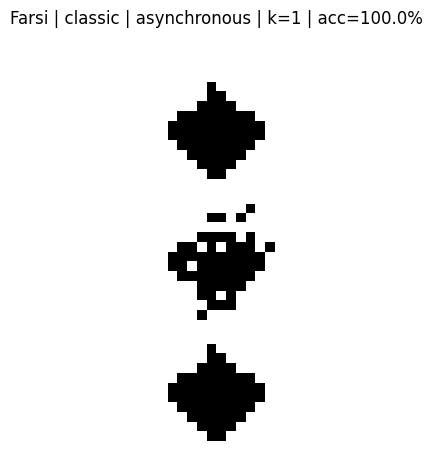

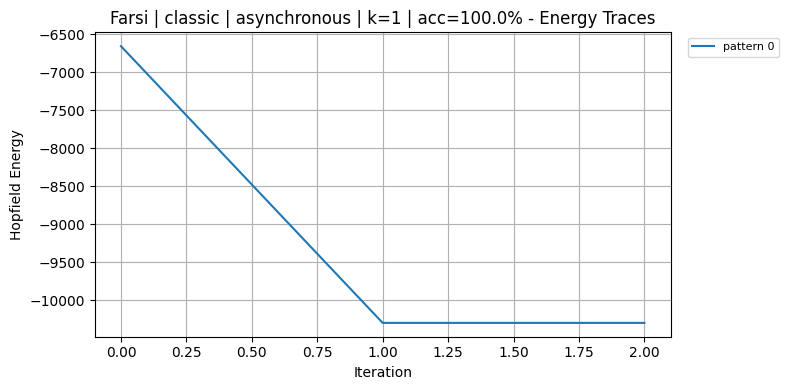

Stored 1 patterns -> accuracy (noisy->original): 100.0%


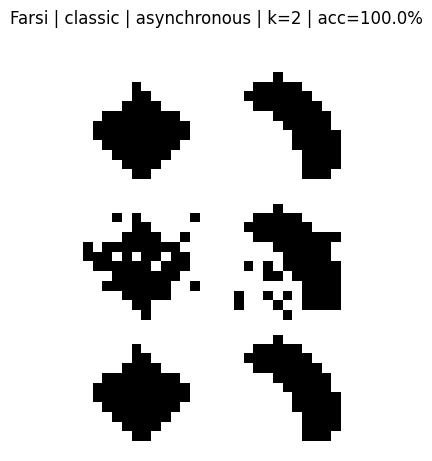

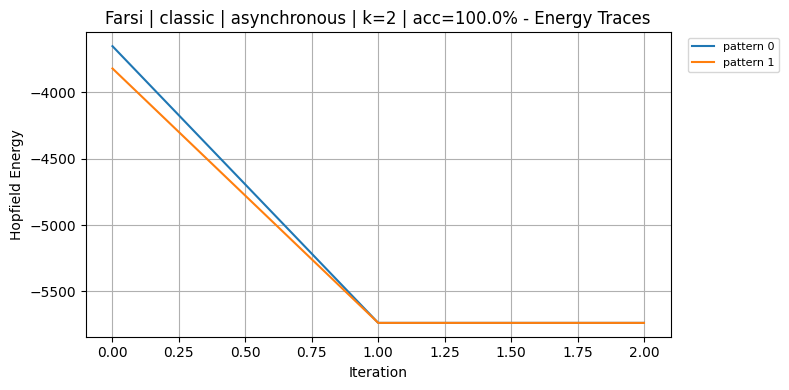

Stored 2 patterns -> accuracy (noisy->original): 100.0%


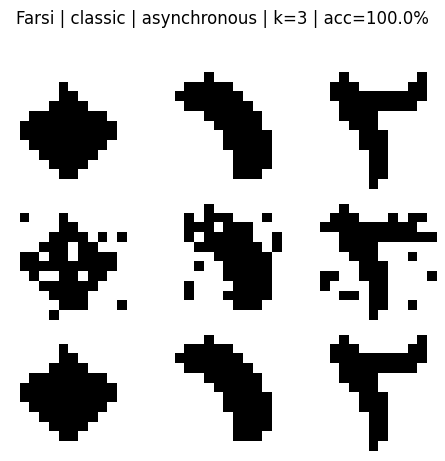

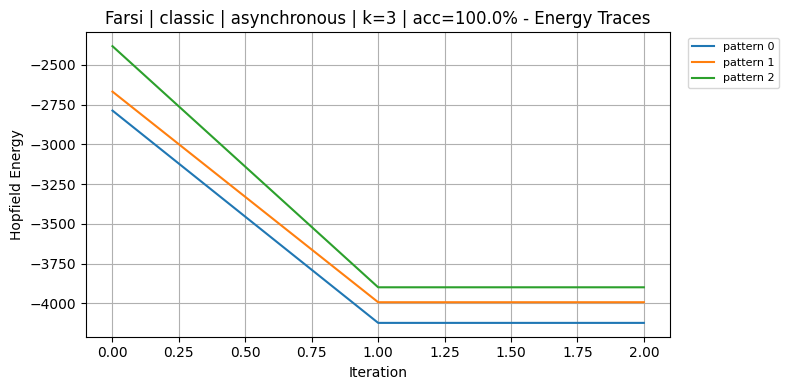

Stored 3 patterns -> accuracy (noisy->original): 100.0%


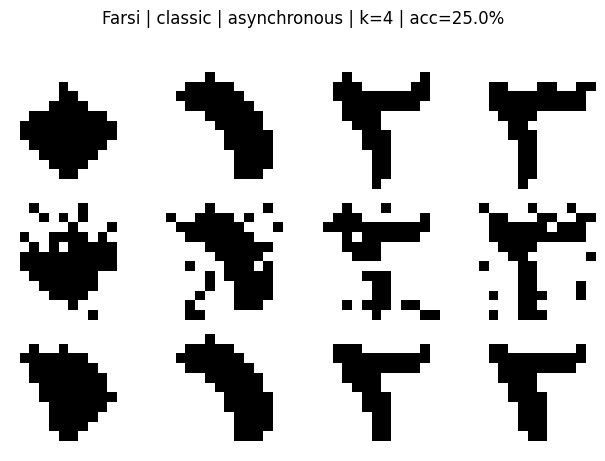

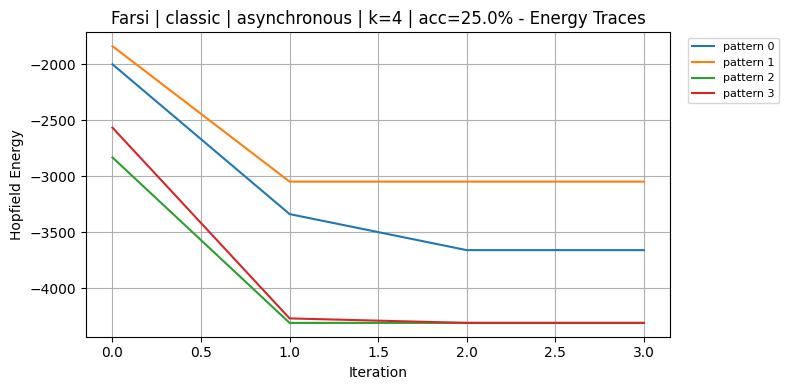

Stored 4 patterns -> accuracy (noisy->original): 25.0%


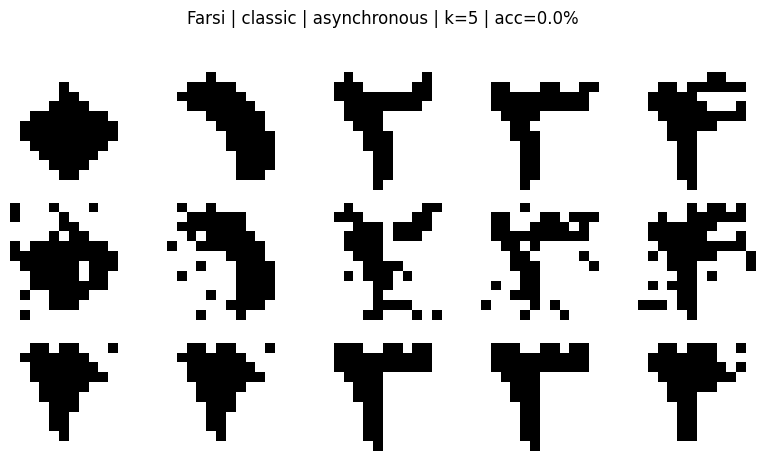

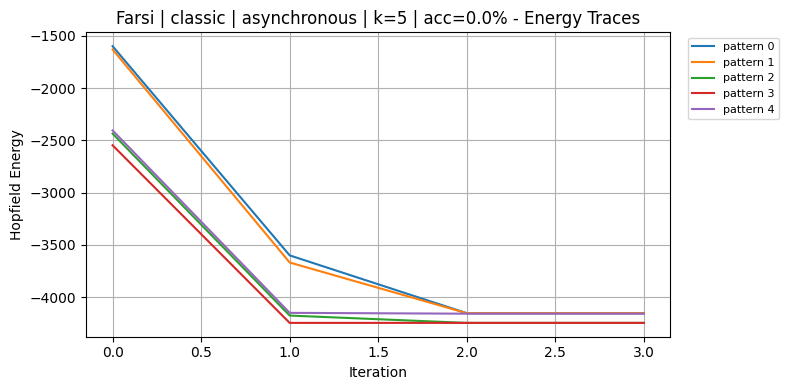

Stored 5 patterns -> accuracy (noisy->original): 0.0%


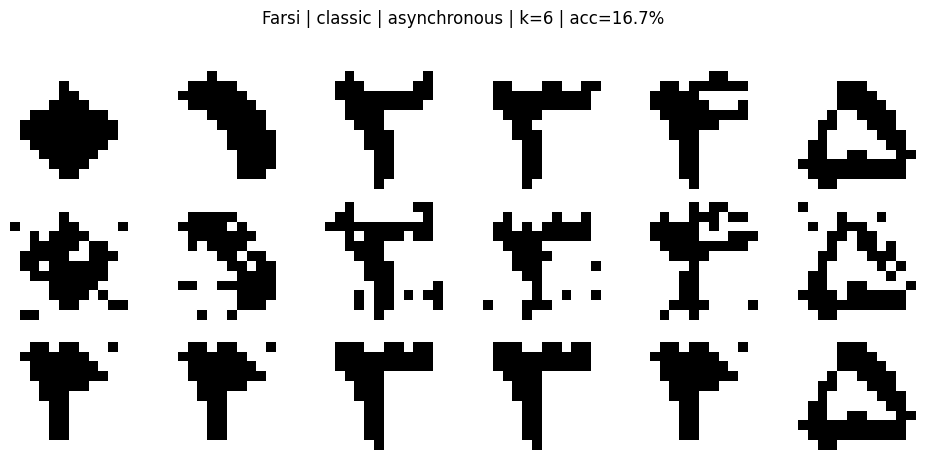

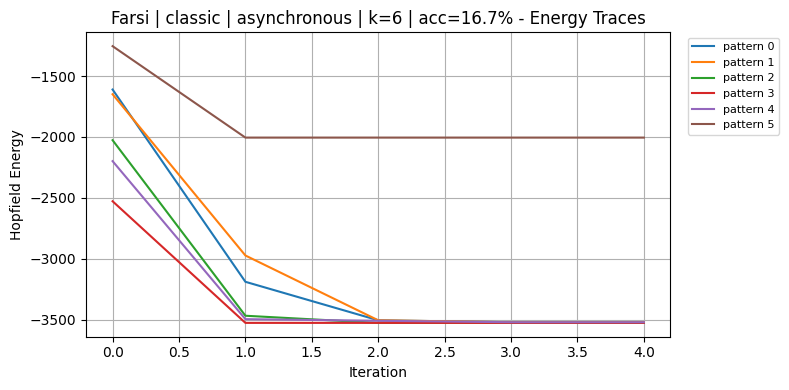

Stored 6 patterns -> accuracy (noisy->original): 16.7%


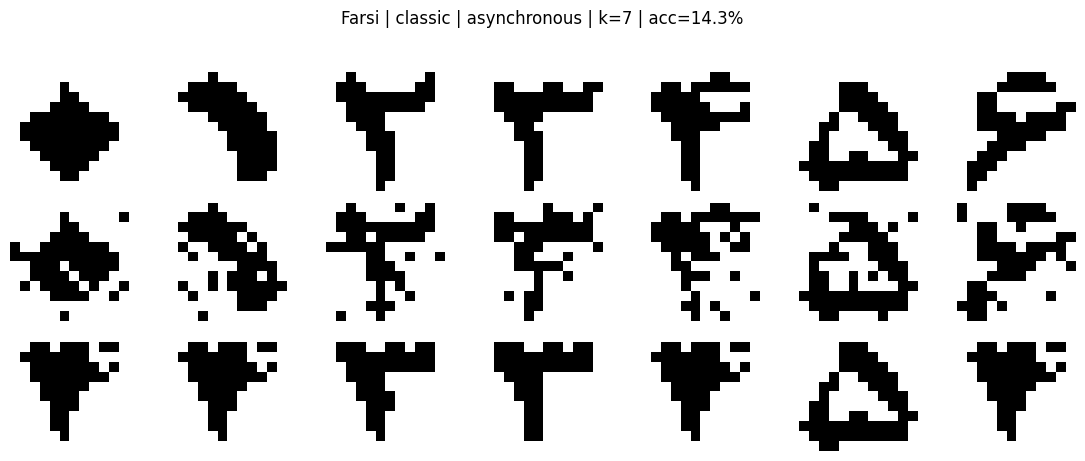

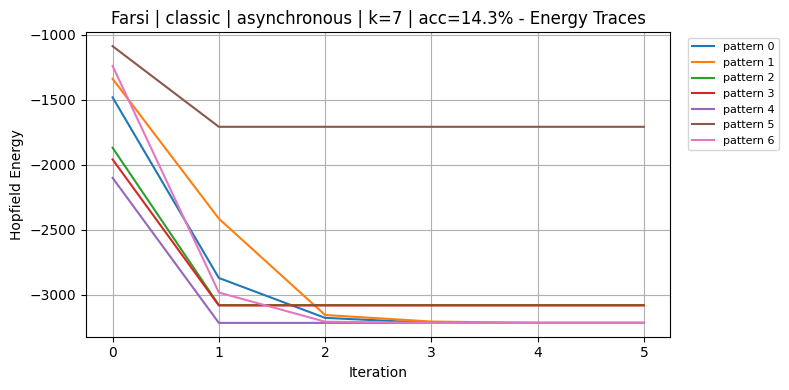

Stored 7 patterns -> accuracy (noisy->original): 14.3%


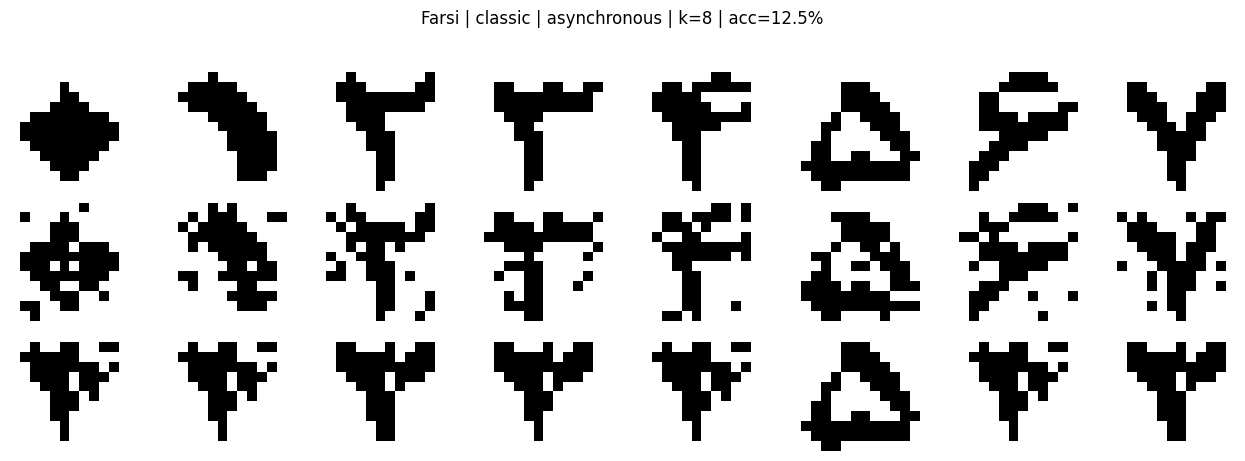

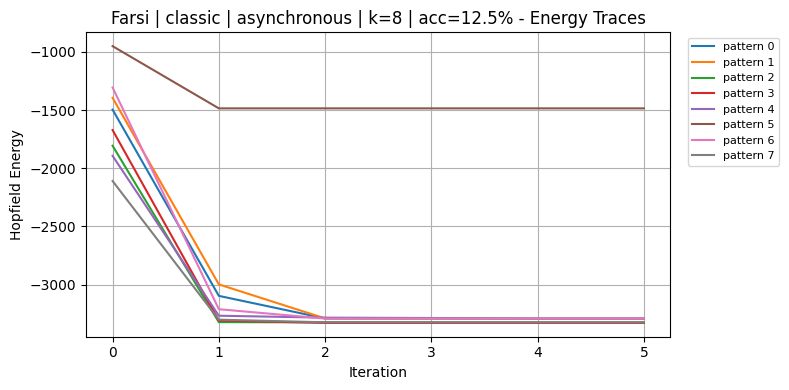

Stored 8 patterns -> accuracy (noisy->original): 12.5%


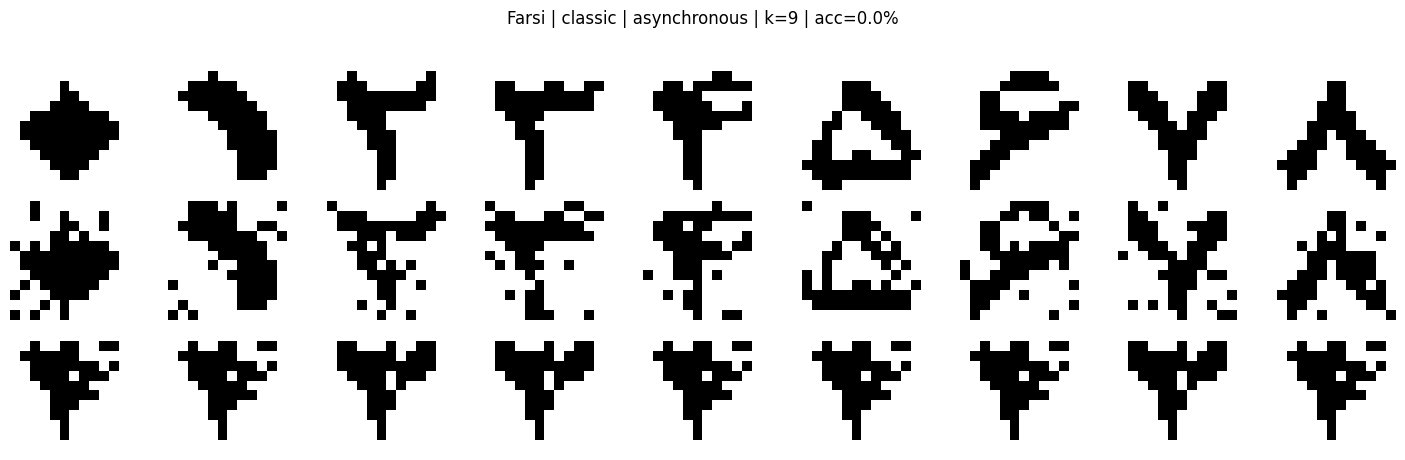

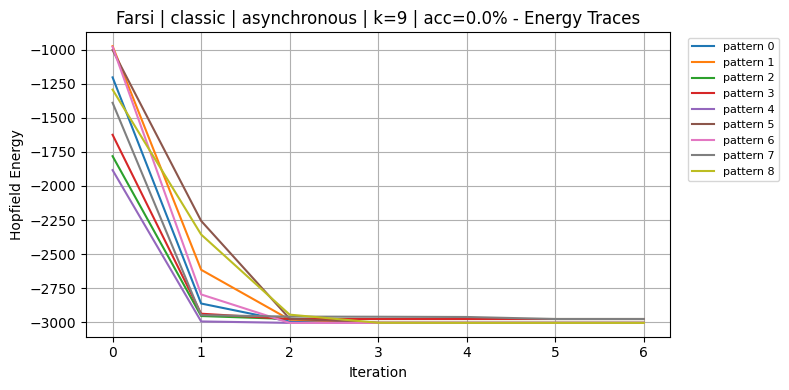

Stored 9 patterns -> accuracy (noisy->original): 0.0%


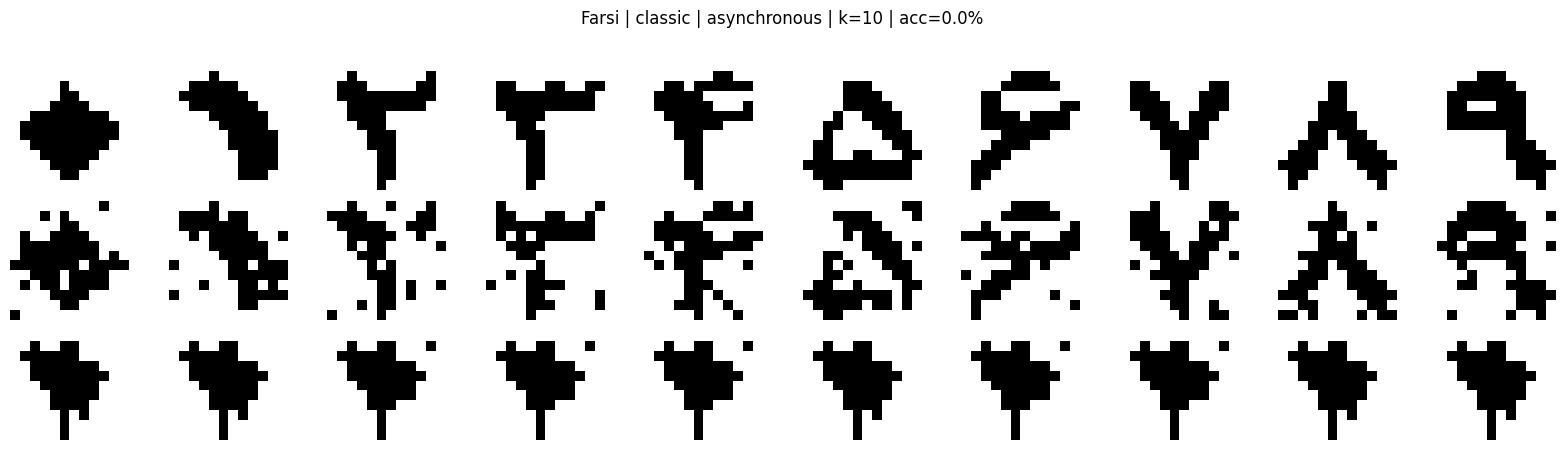

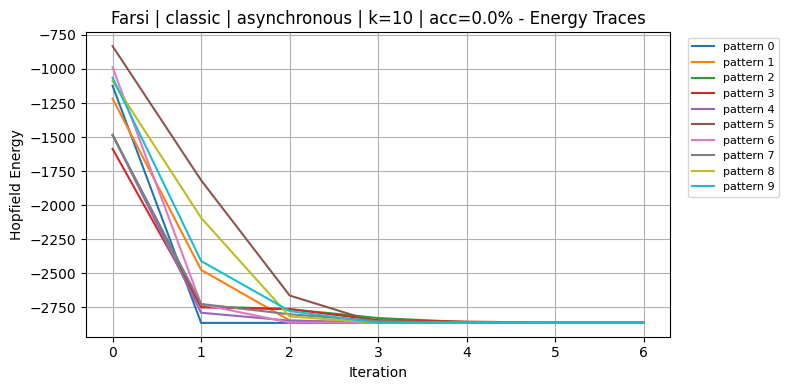

Stored 10 patterns -> accuracy (noisy->original): 0.0%
k=2: accuracy=100.0%
k=3: accuracy=100.0%
k=4: accuracy=50.0%
k=5: accuracy=0.0%
k=6: accuracy=16.7%
k=7: accuracy=14.3%
k=8: accuracy=12.5%
k=9: accuracy=0.0%
k=10: accuracy=0.0%


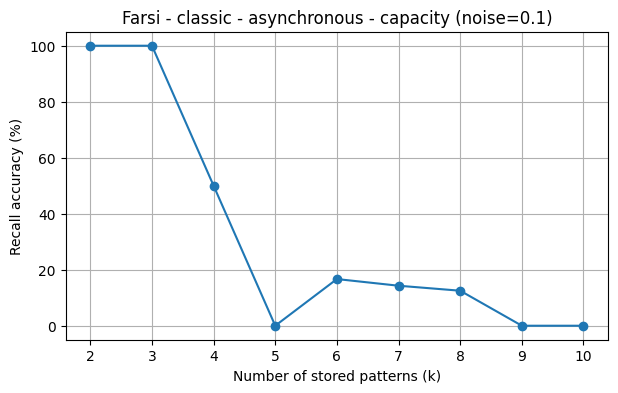

\n>> Running Farsi | modified | asynchronous

=== Farsi | rule=modified | strategy=asynchronous ===


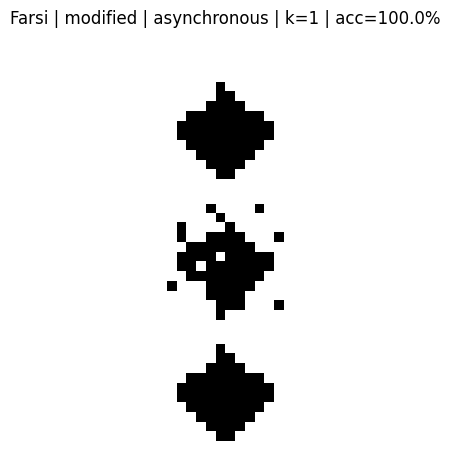

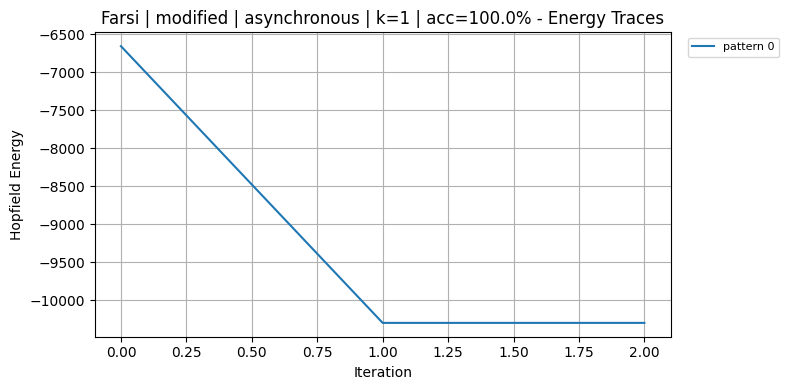

Stored 1 patterns -> accuracy (noisy->original): 100.0%


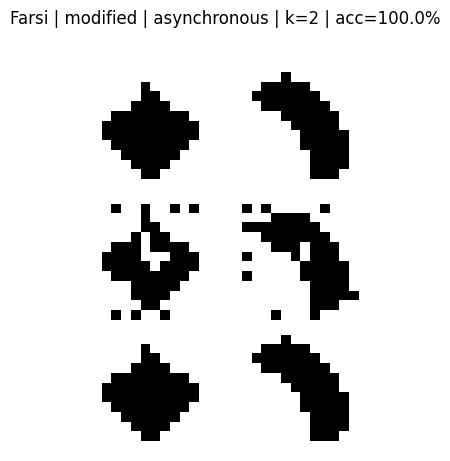

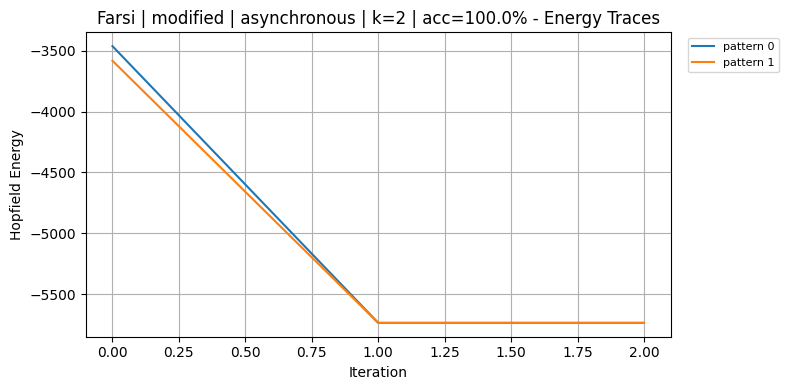

Stored 2 patterns -> accuracy (noisy->original): 100.0%


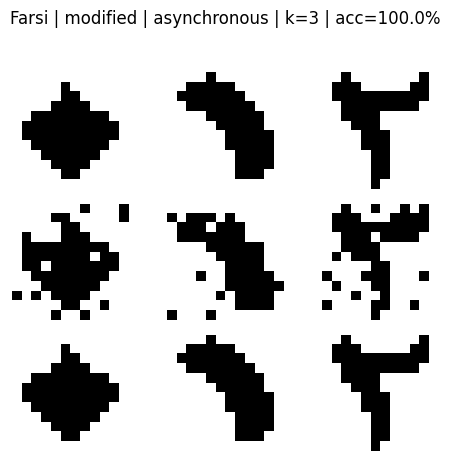

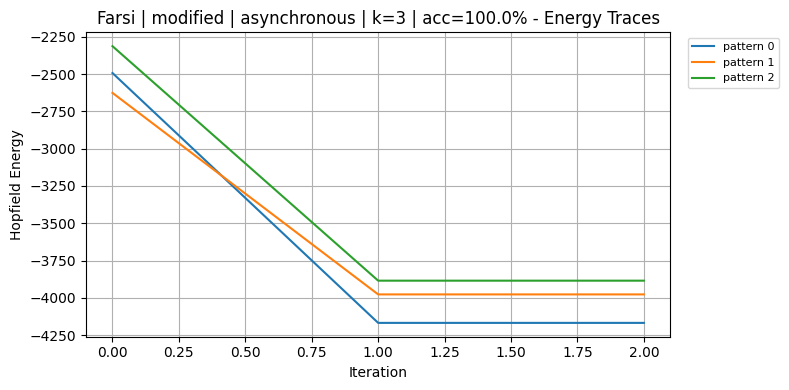

Stored 3 patterns -> accuracy (noisy->original): 100.0%


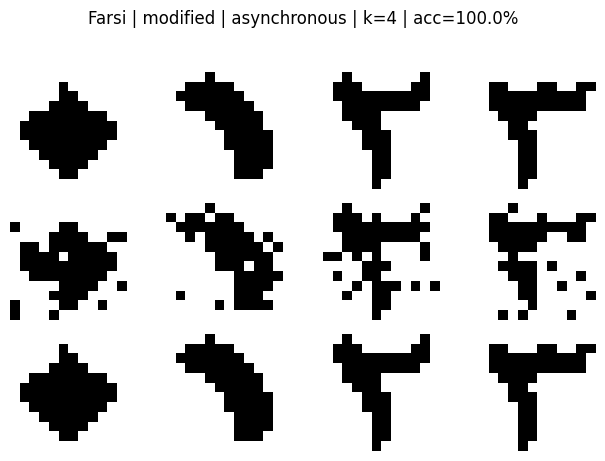

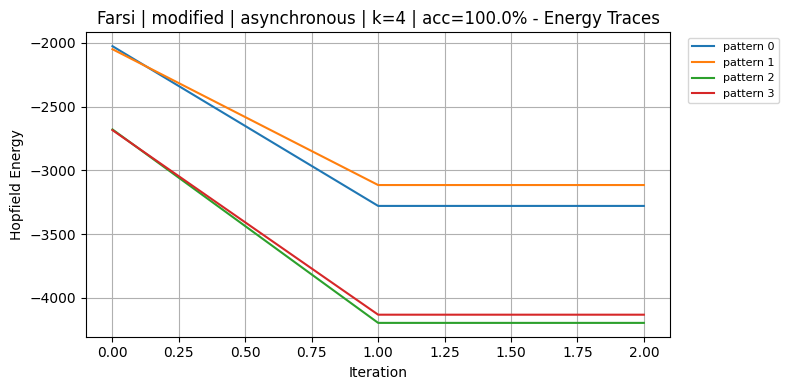

Stored 4 patterns -> accuracy (noisy->original): 100.0%


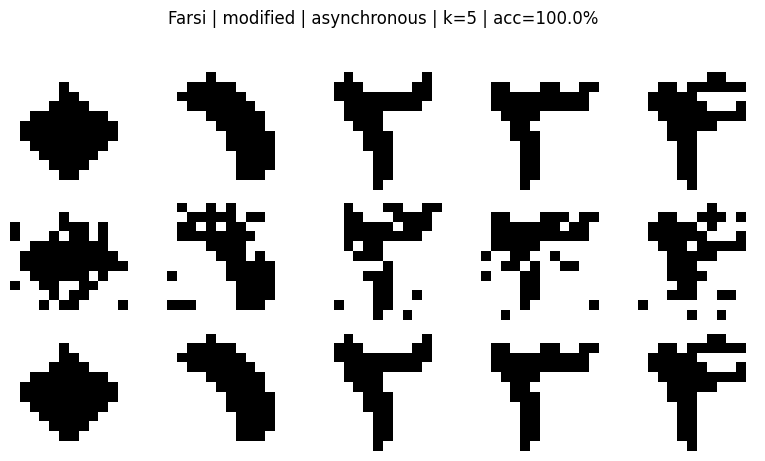

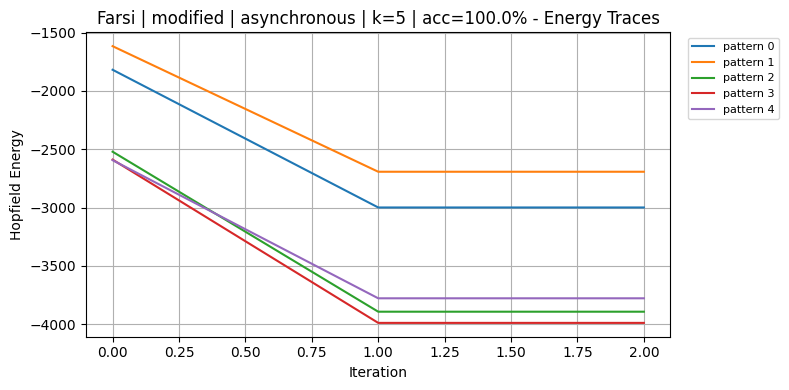

Stored 5 patterns -> accuracy (noisy->original): 100.0%


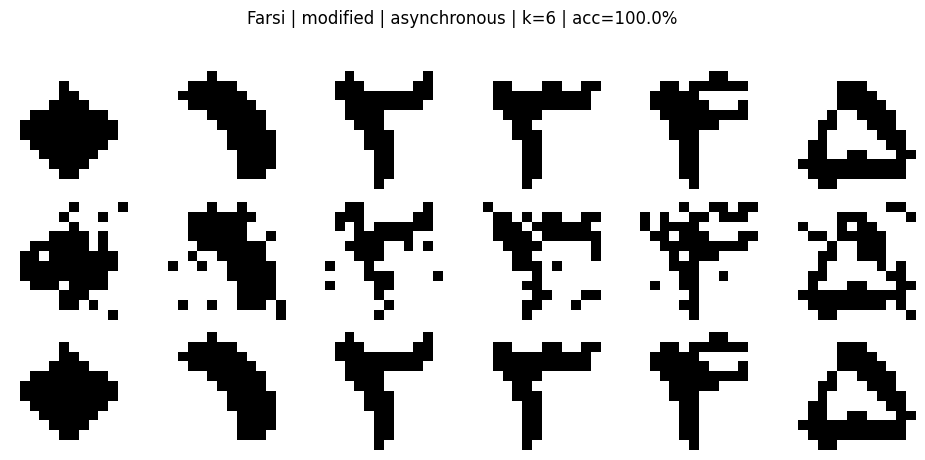

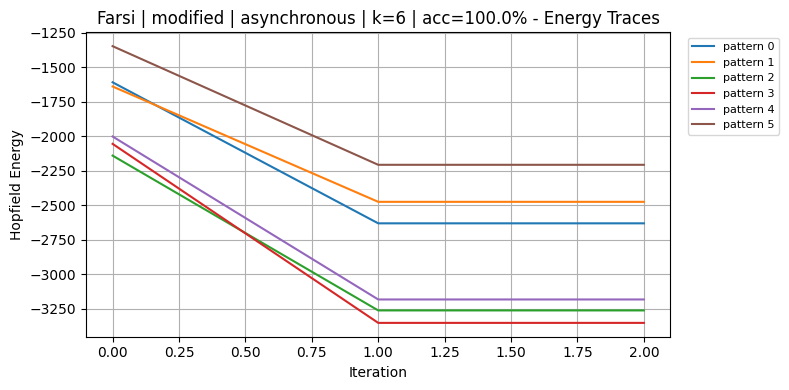

Stored 6 patterns -> accuracy (noisy->original): 100.0%


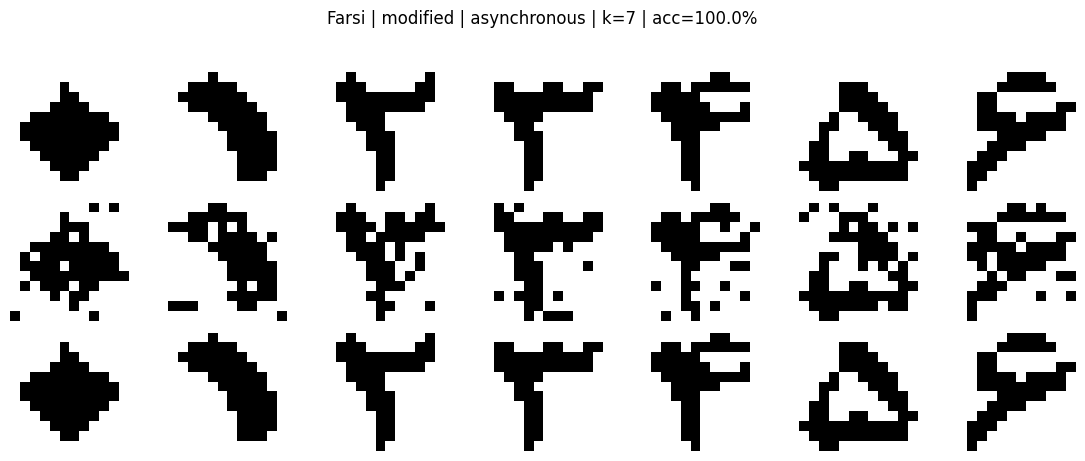

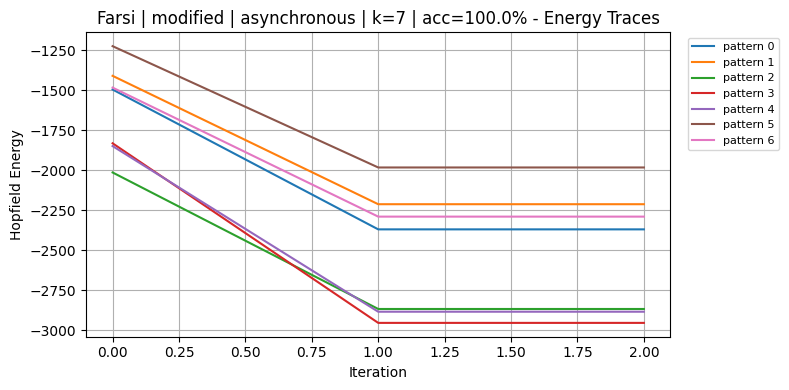

Stored 7 patterns -> accuracy (noisy->original): 100.0%


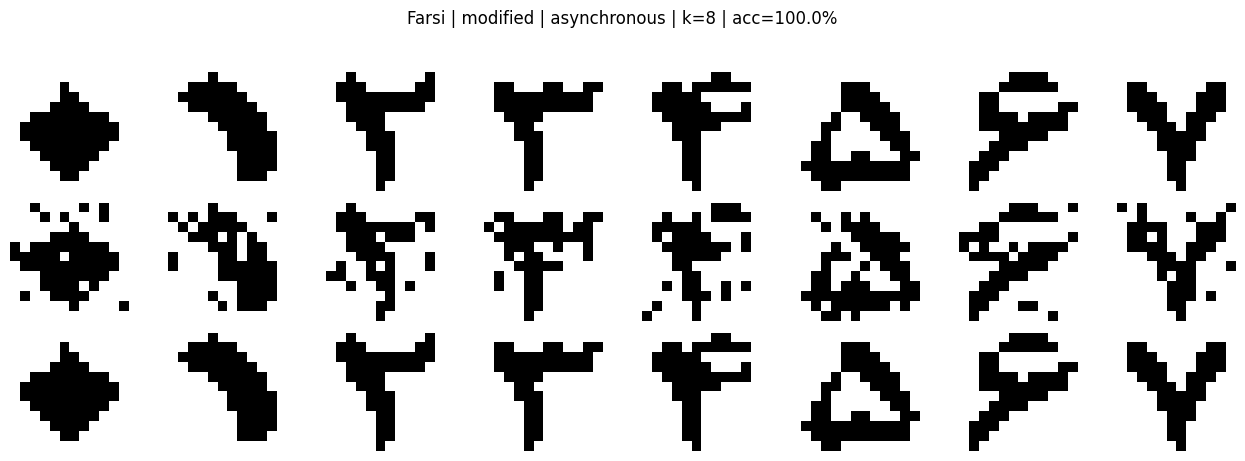

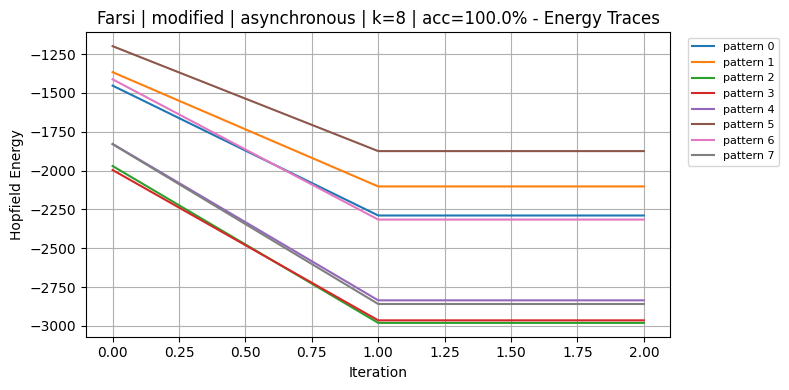

Stored 8 patterns -> accuracy (noisy->original): 100.0%


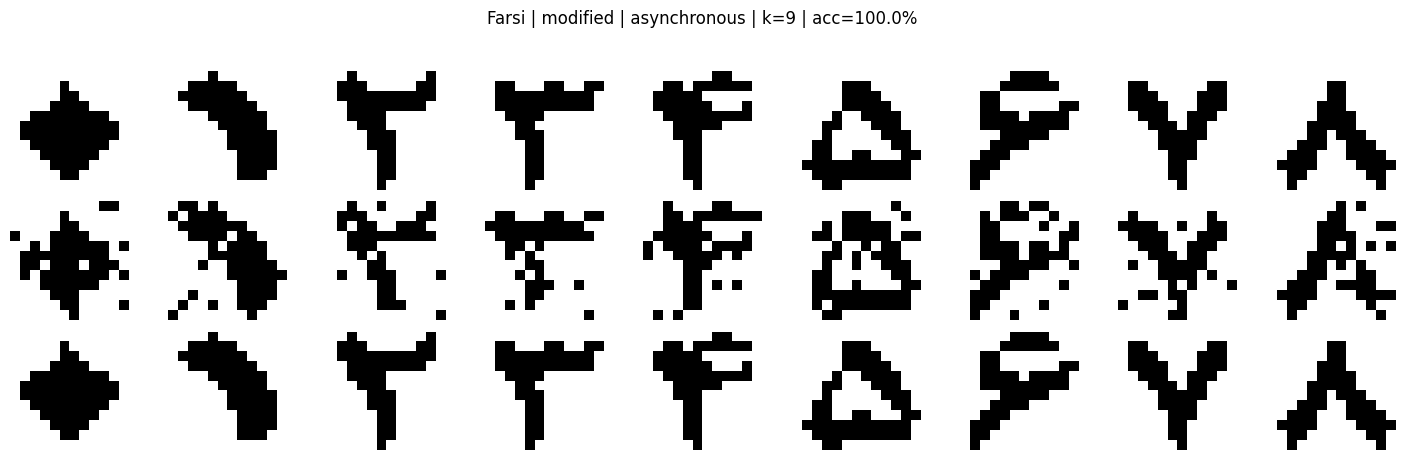

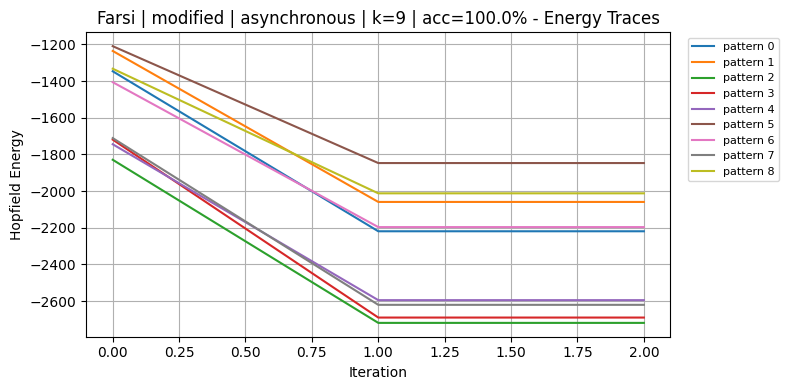

Stored 9 patterns -> accuracy (noisy->original): 100.0%


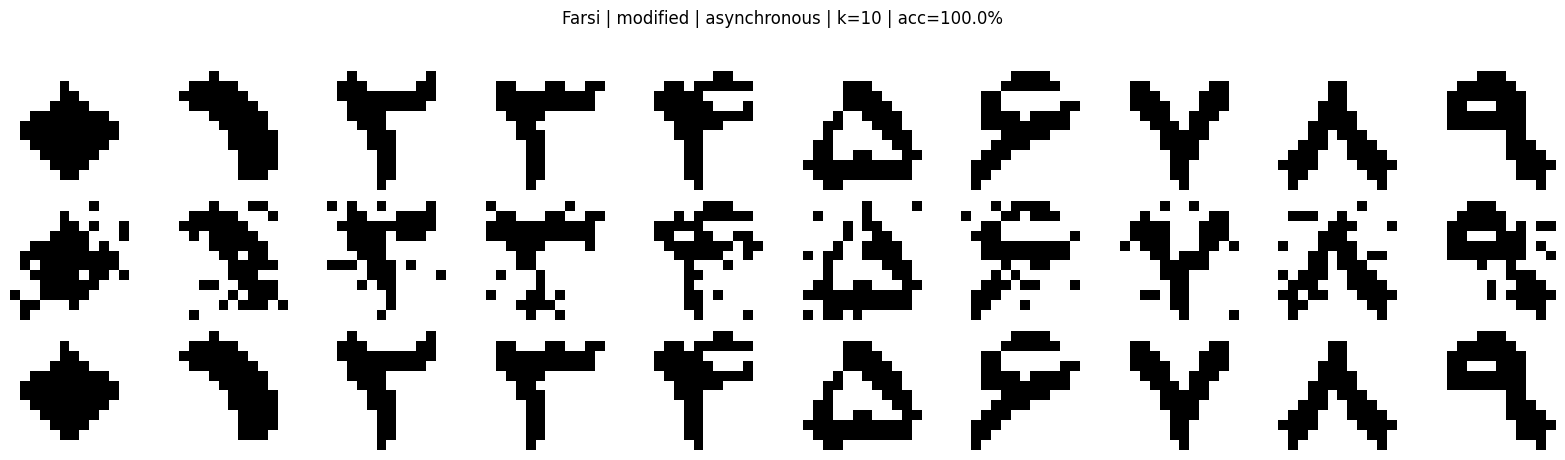

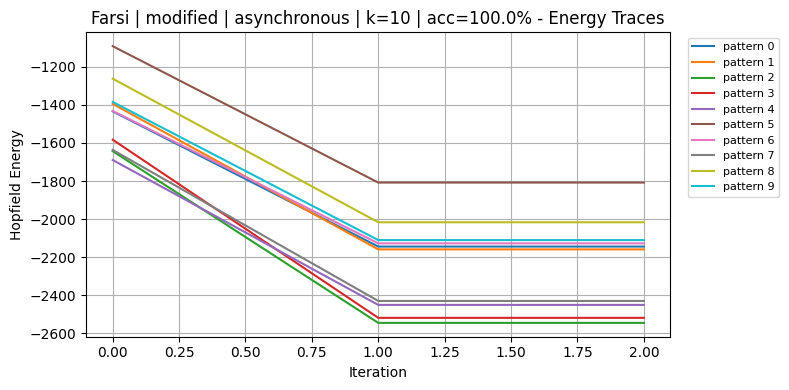

Stored 10 patterns -> accuracy (noisy->original): 100.0%
k=2: accuracy=100.0%
k=3: accuracy=100.0%
k=4: accuracy=100.0%
k=5: accuracy=100.0%
k=6: accuracy=100.0%
k=7: accuracy=100.0%
k=8: accuracy=100.0%
k=9: accuracy=100.0%
k=10: accuracy=100.0%


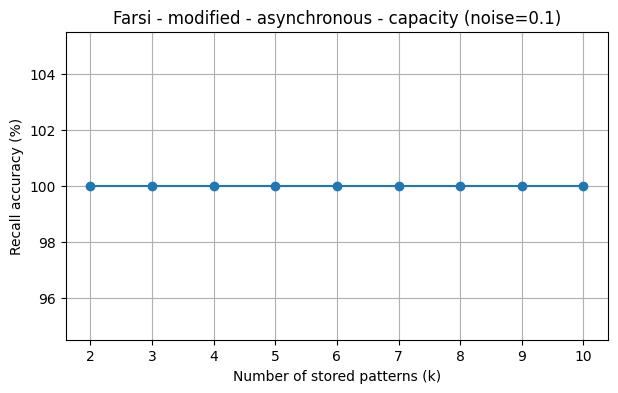

\n>> Running Farsi | classic | synchronous

=== Farsi | rule=classic | strategy=synchronous ===


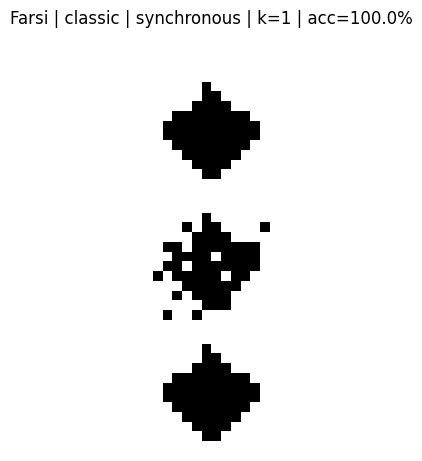

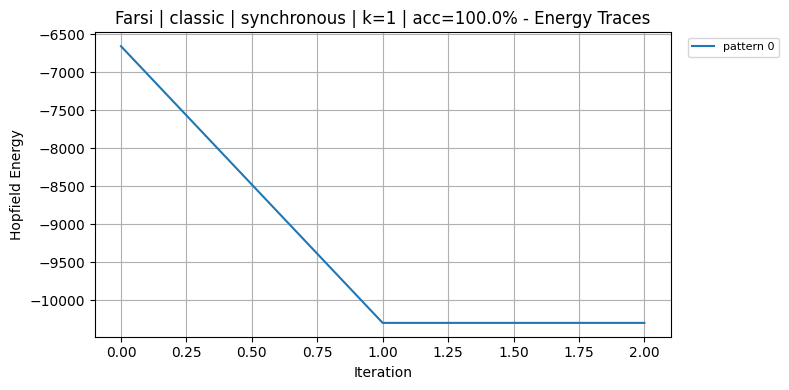

Stored 1 patterns -> accuracy (noisy->original): 100.0%


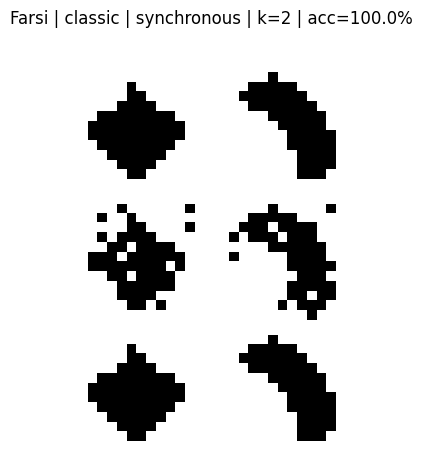

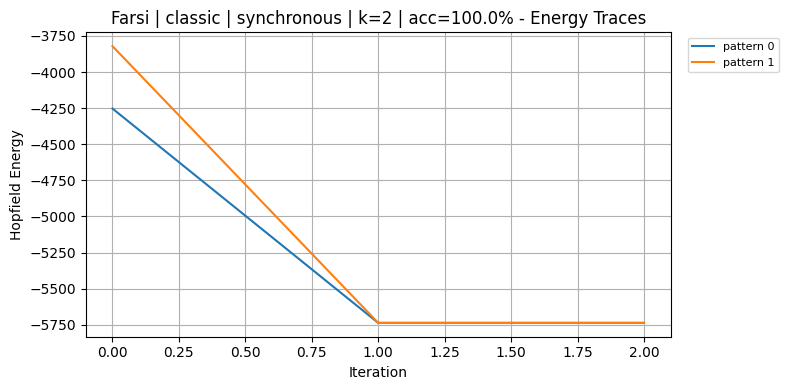

Stored 2 patterns -> accuracy (noisy->original): 100.0%


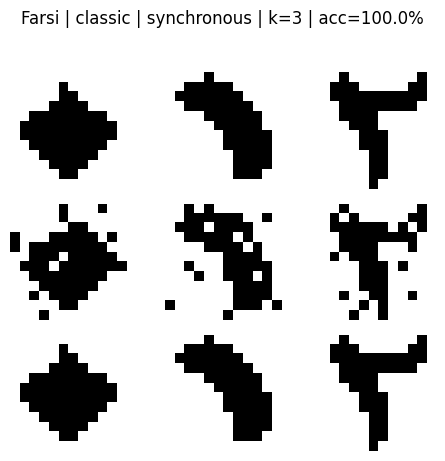

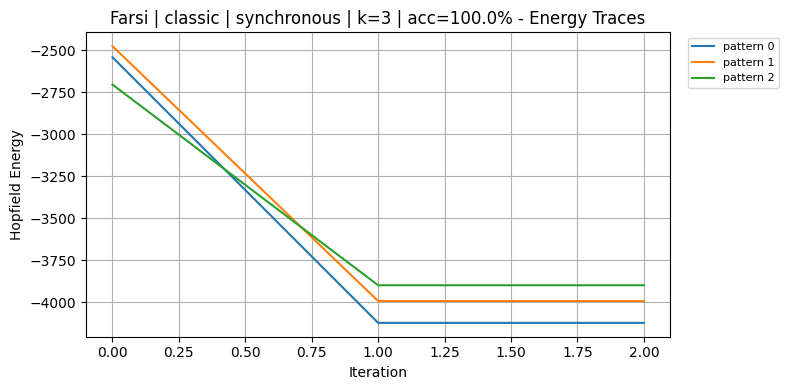

Stored 3 patterns -> accuracy (noisy->original): 100.0%


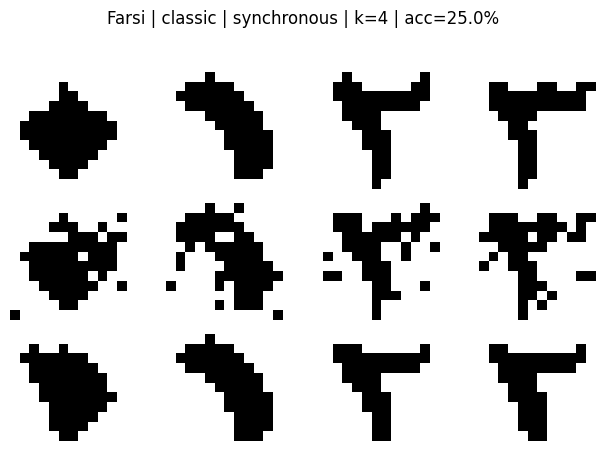

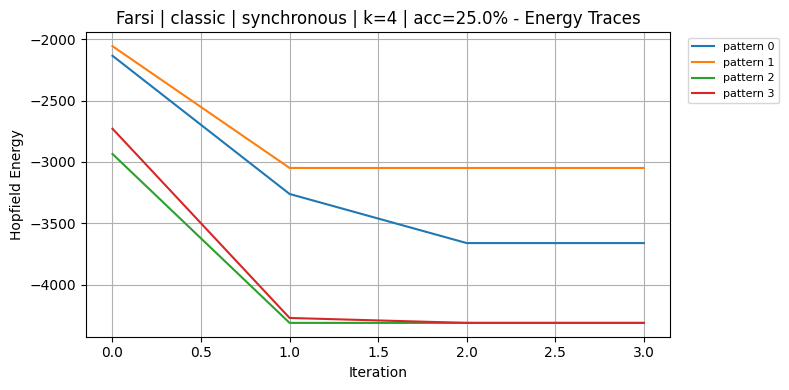

Stored 4 patterns -> accuracy (noisy->original): 25.0%


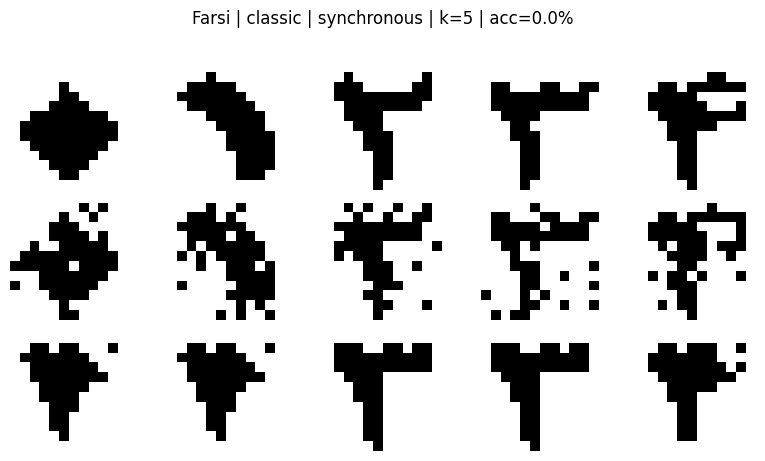

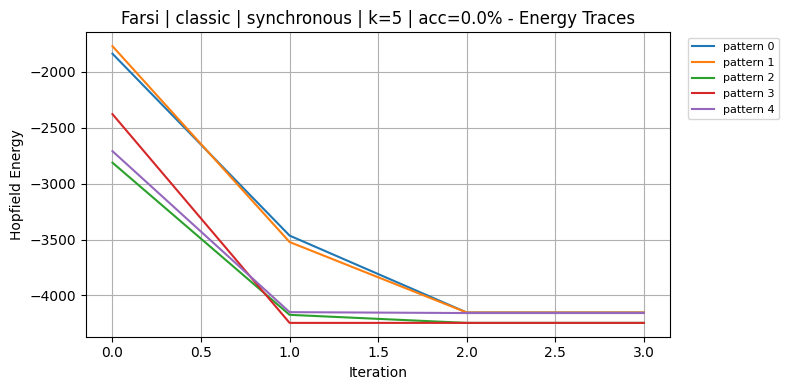

Stored 5 patterns -> accuracy (noisy->original): 0.0%


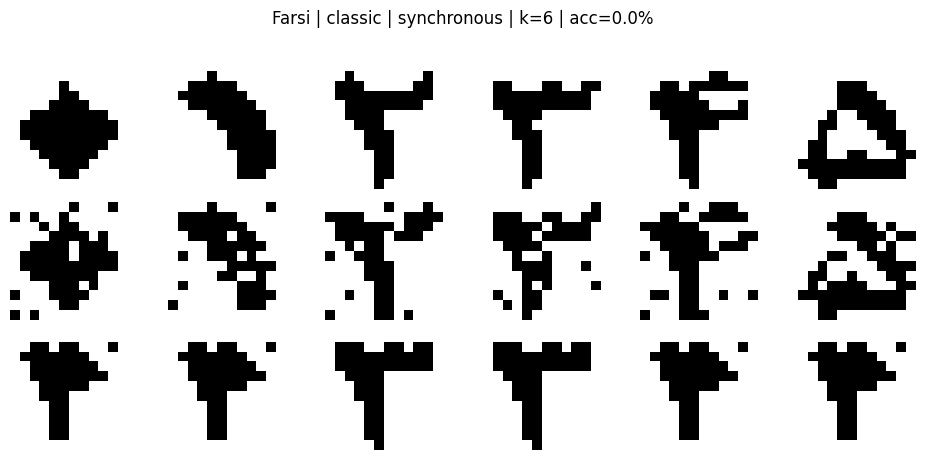

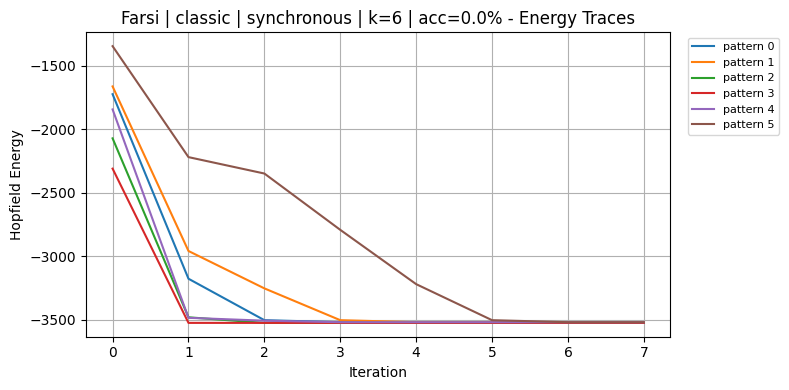

Stored 6 patterns -> accuracy (noisy->original): 0.0%


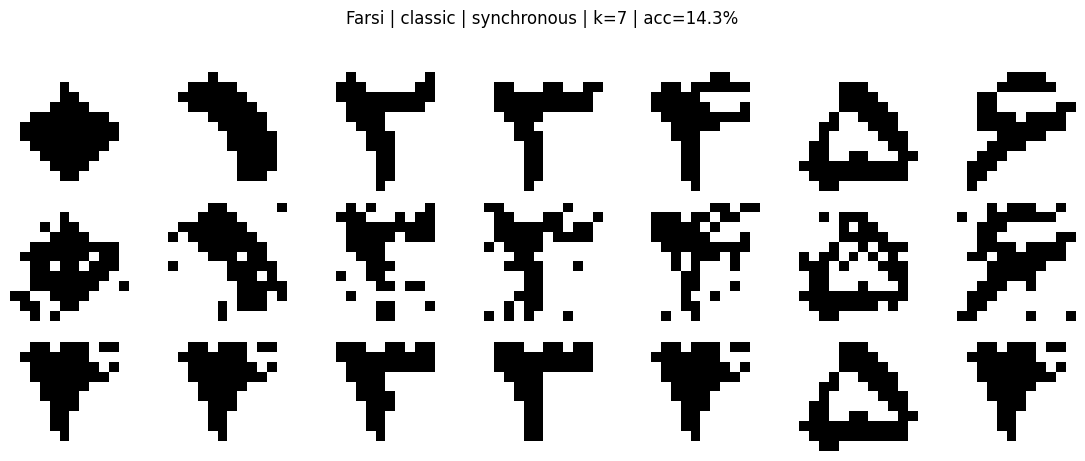

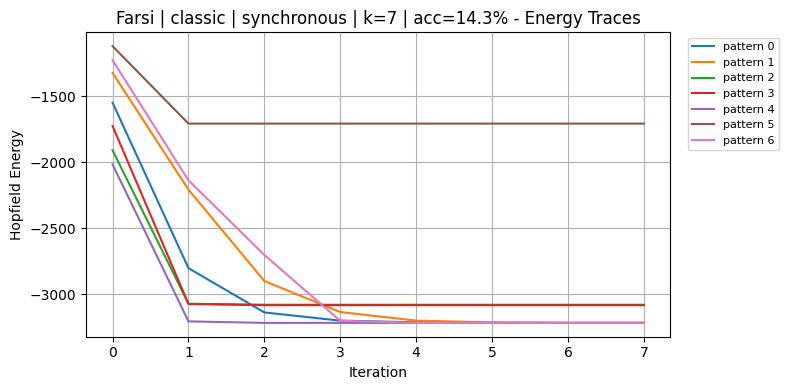

Stored 7 patterns -> accuracy (noisy->original): 14.3%


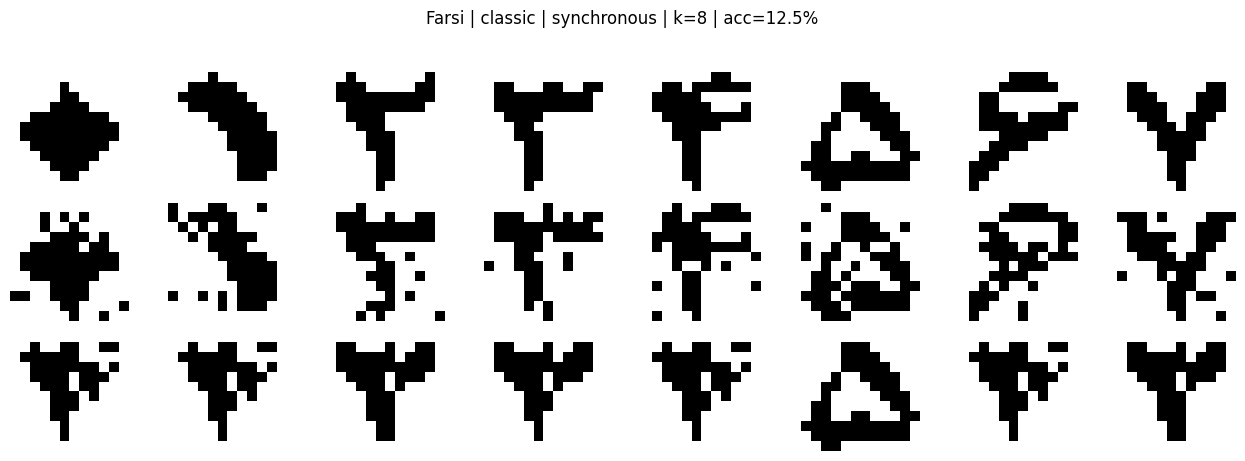

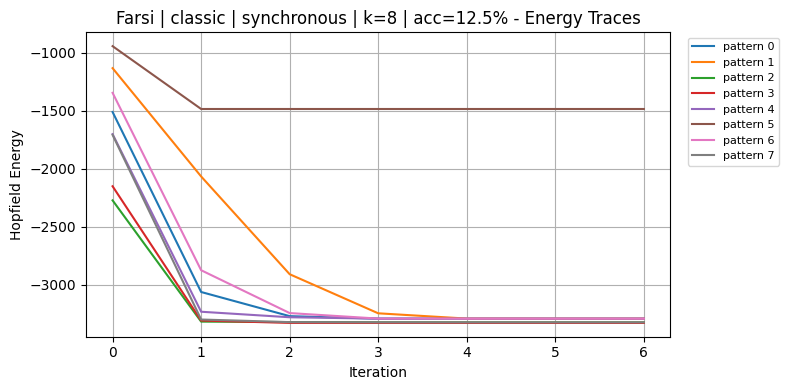

Stored 8 patterns -> accuracy (noisy->original): 12.5%


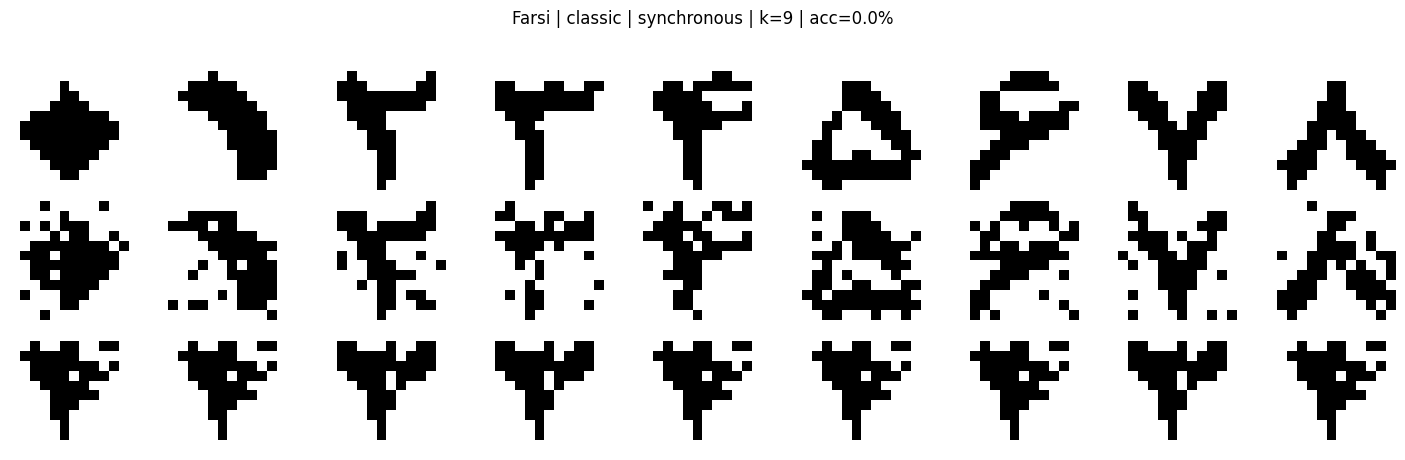

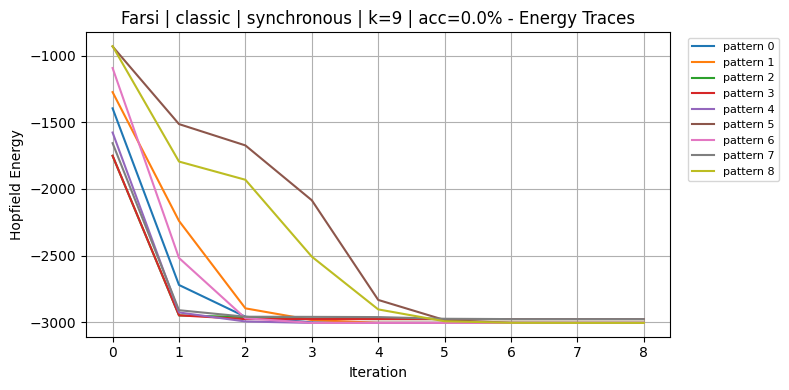

Stored 9 patterns -> accuracy (noisy->original): 0.0%


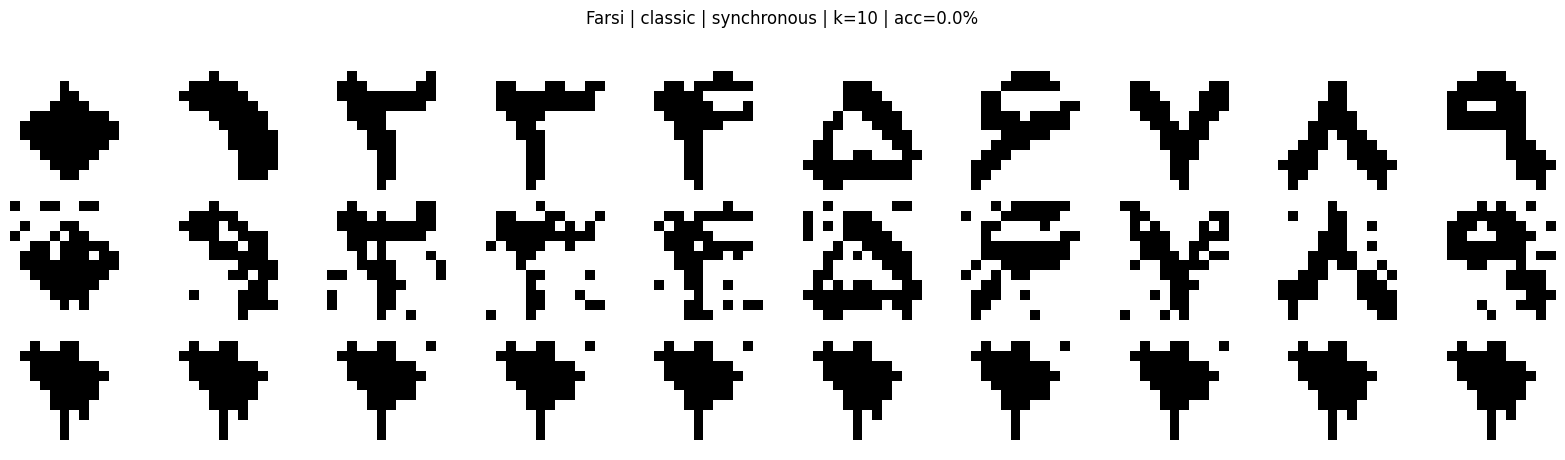

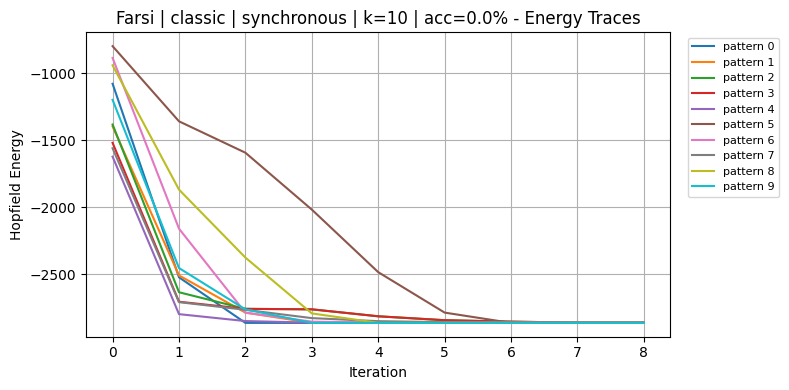

Stored 10 patterns -> accuracy (noisy->original): 0.0%
k=2: accuracy=100.0%
k=3: accuracy=100.0%
k=4: accuracy=25.0%
k=5: accuracy=0.0%
k=6: accuracy=16.7%
k=7: accuracy=14.3%
k=8: accuracy=12.5%
k=9: accuracy=0.0%
k=10: accuracy=0.0%


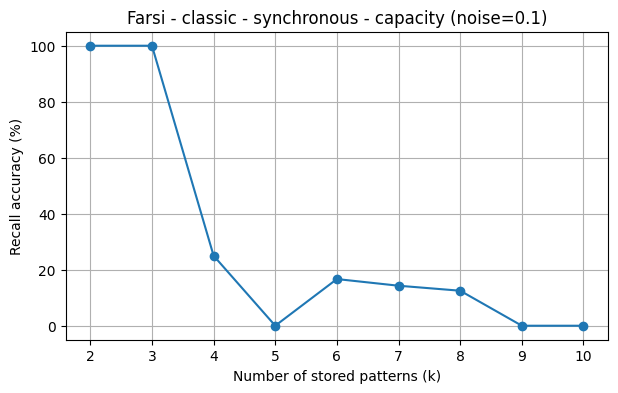

\n>> Running Farsi | modified | synchronous

=== Farsi | rule=modified | strategy=synchronous ===


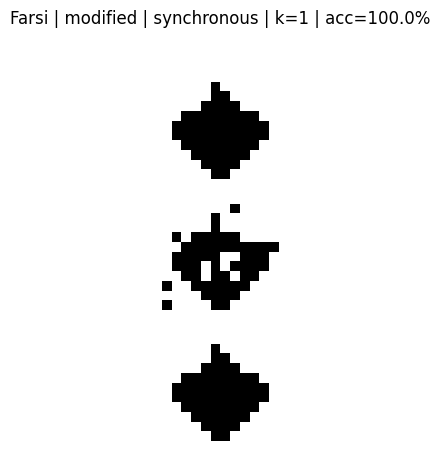

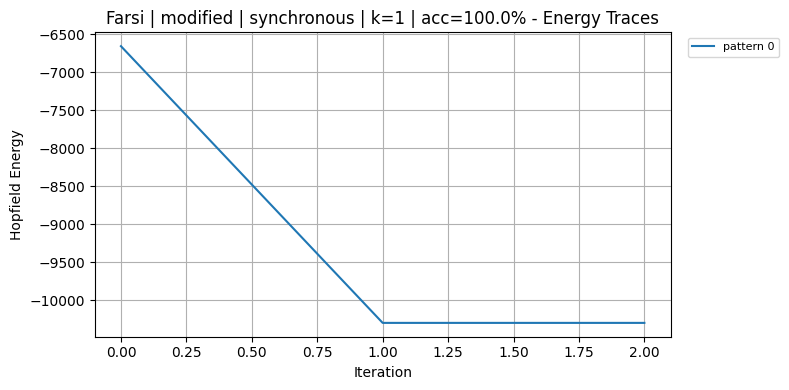

Stored 1 patterns -> accuracy (noisy->original): 100.0%


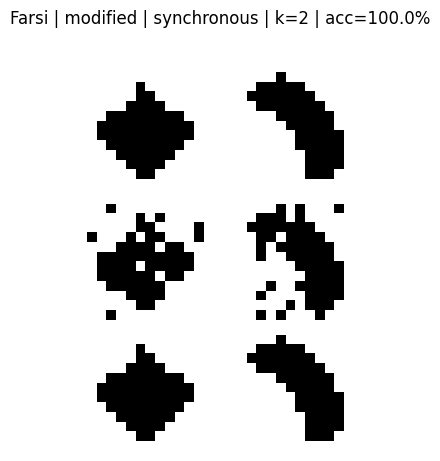

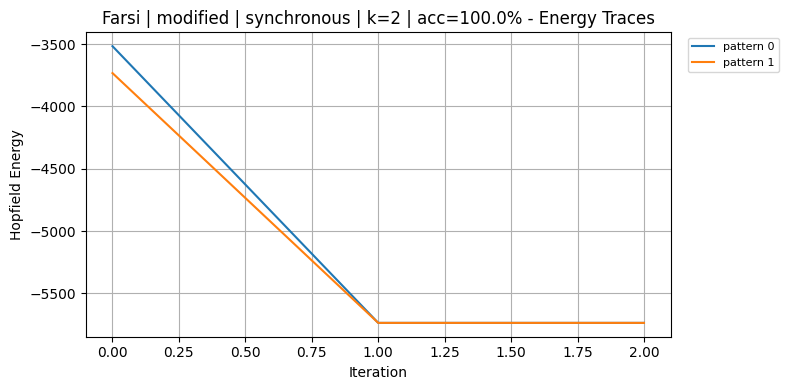

Stored 2 patterns -> accuracy (noisy->original): 100.0%


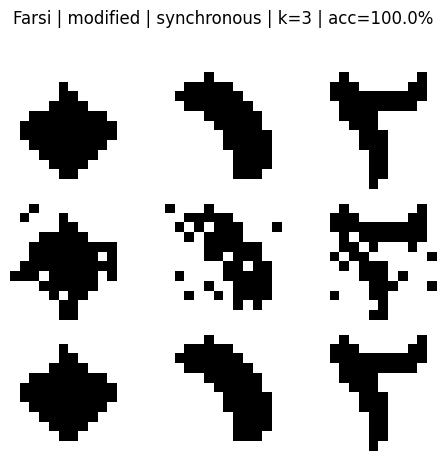

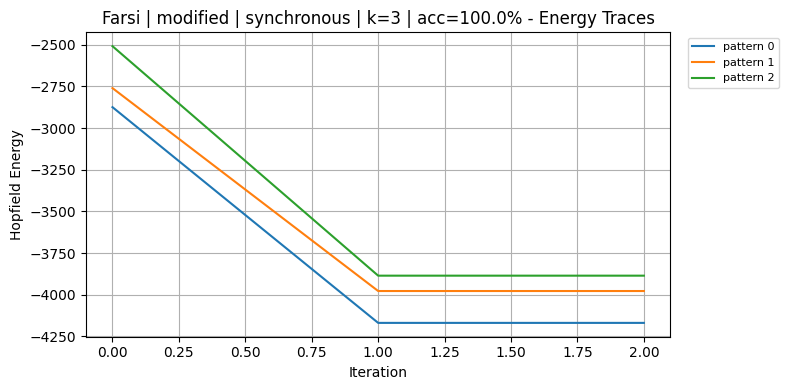

Stored 3 patterns -> accuracy (noisy->original): 100.0%


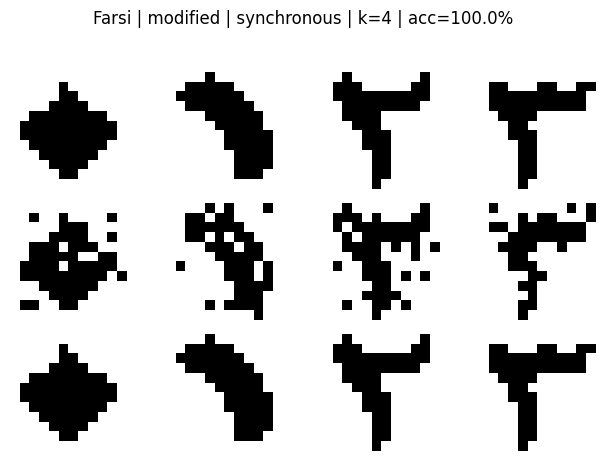

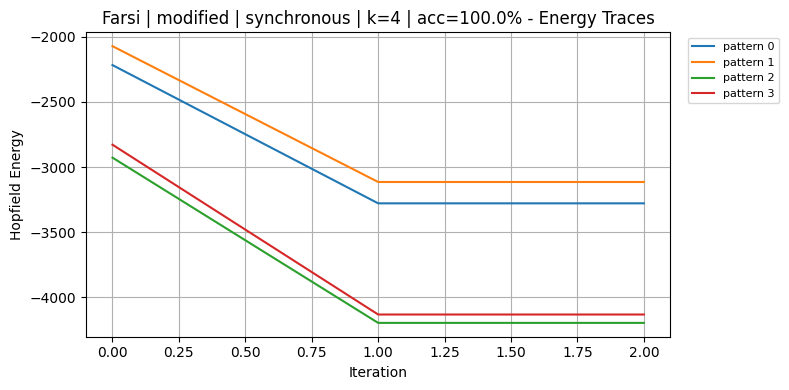

Stored 4 patterns -> accuracy (noisy->original): 100.0%


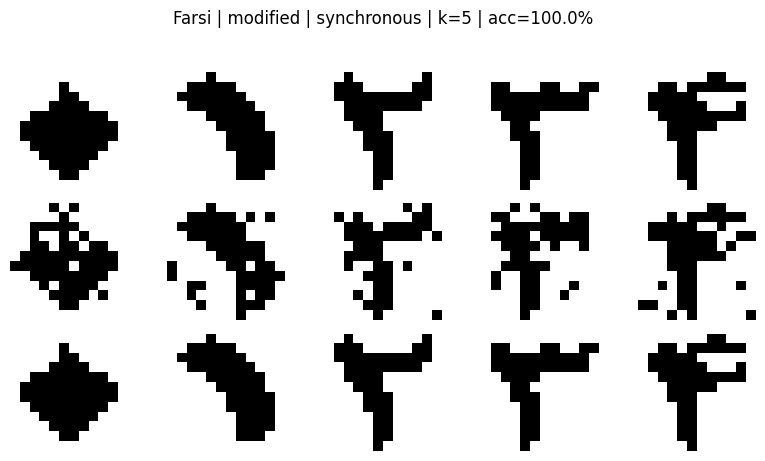

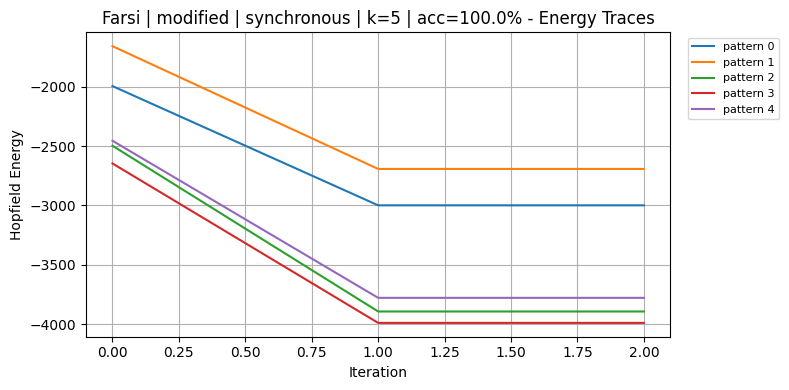

Stored 5 patterns -> accuracy (noisy->original): 100.0%


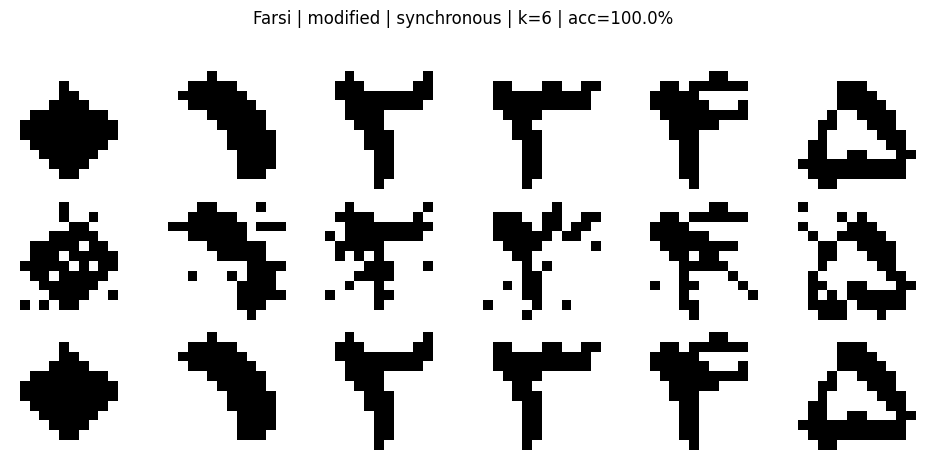

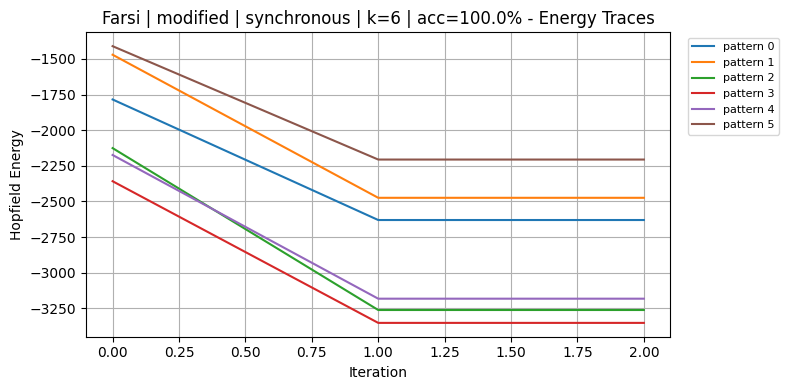

Stored 6 patterns -> accuracy (noisy->original): 100.0%


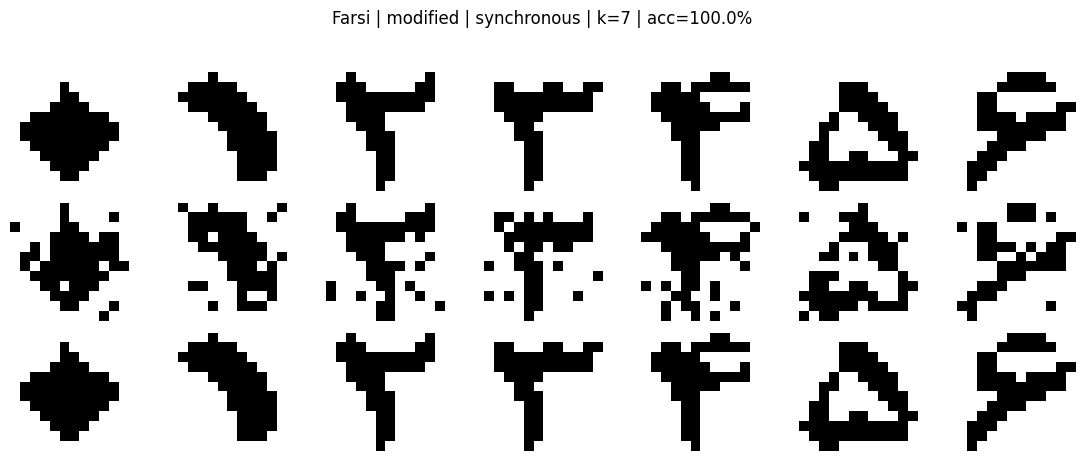

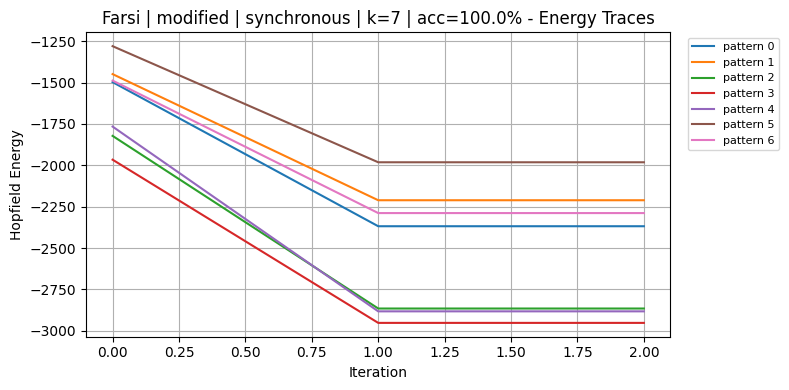

Stored 7 patterns -> accuracy (noisy->original): 100.0%


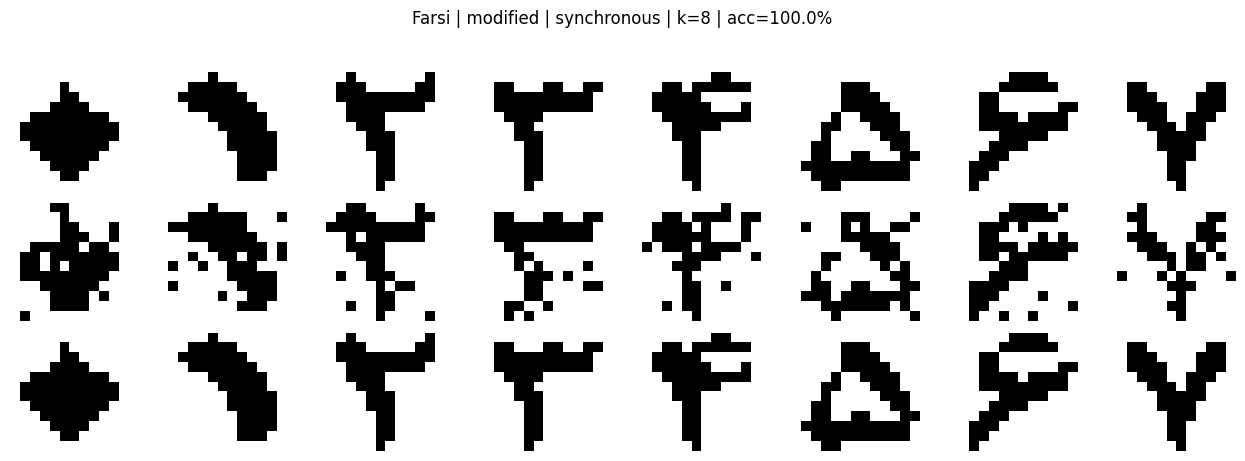

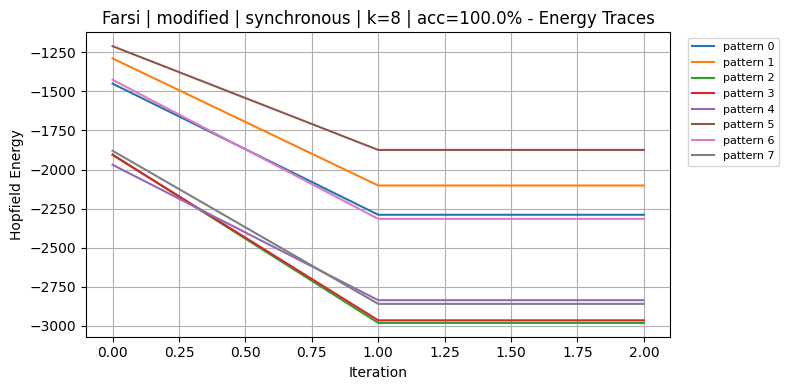

Stored 8 patterns -> accuracy (noisy->original): 100.0%


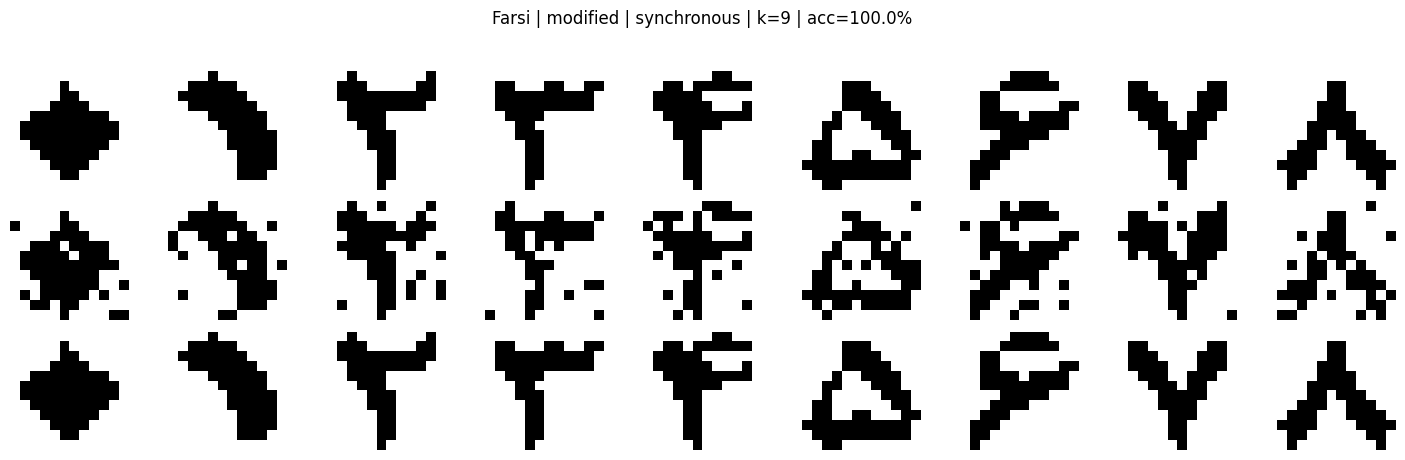

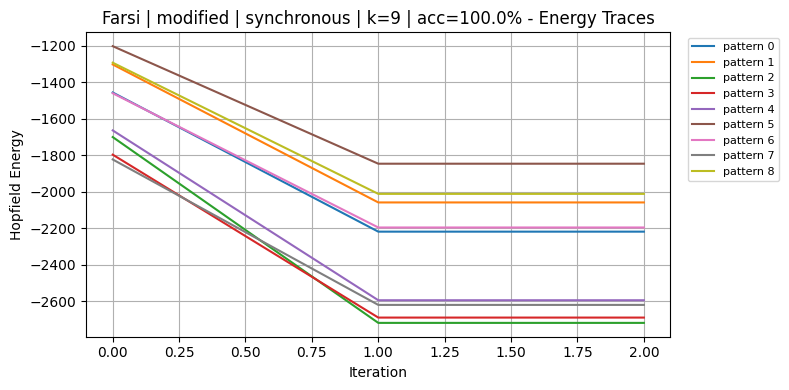

Stored 9 patterns -> accuracy (noisy->original): 100.0%


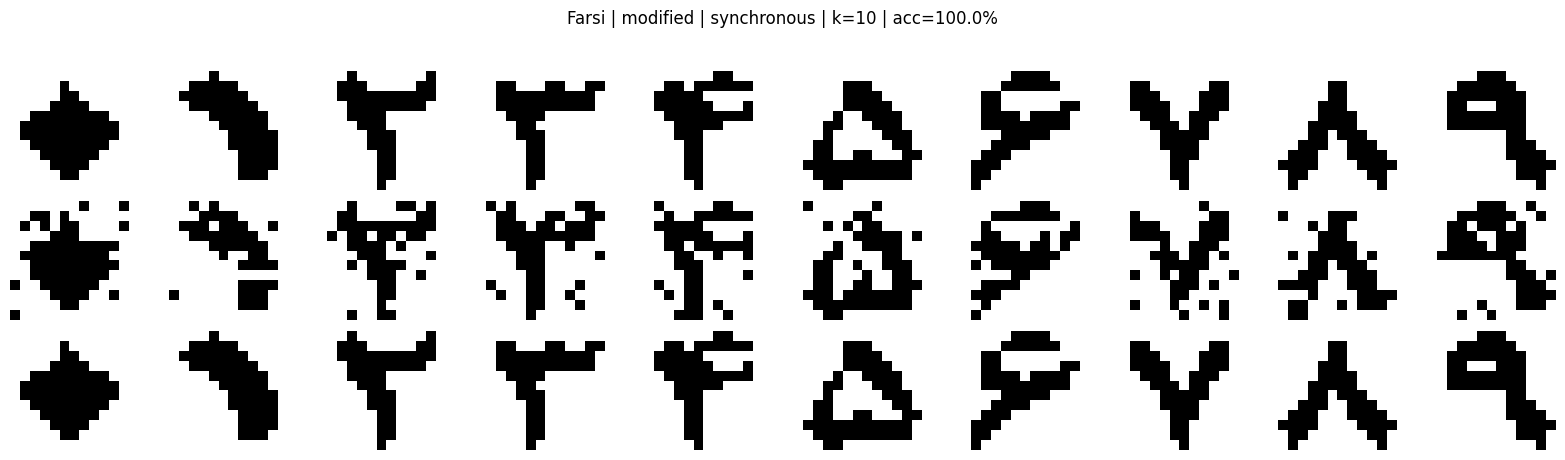

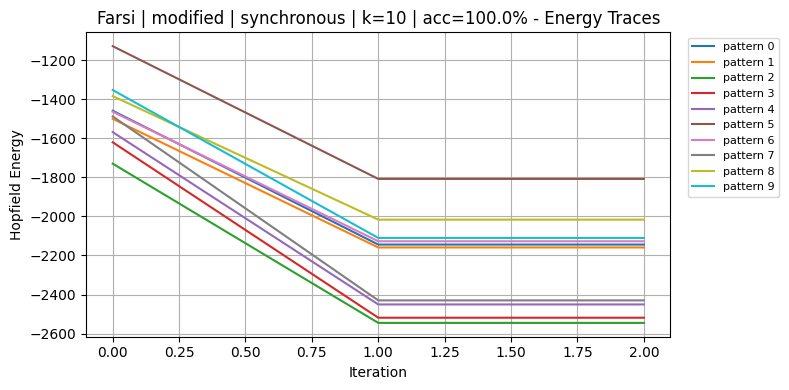

Stored 10 patterns -> accuracy (noisy->original): 100.0%
k=2: accuracy=100.0%
k=3: accuracy=100.0%
k=4: accuracy=100.0%
k=5: accuracy=100.0%
k=6: accuracy=100.0%
k=7: accuracy=100.0%
k=8: accuracy=100.0%
k=9: accuracy=100.0%
k=10: accuracy=100.0%


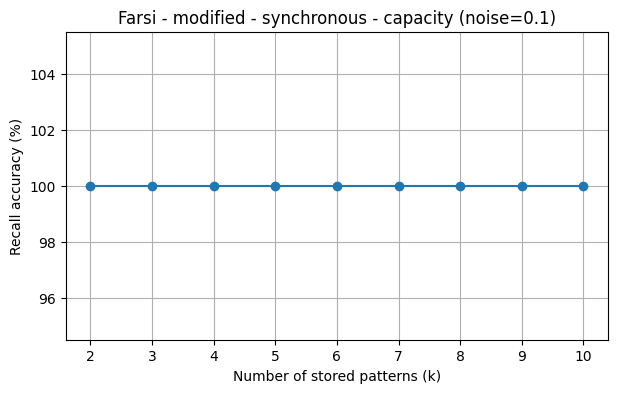

In [46]:
farsi_results = run_all_configurations(farsi_patterns, 'Farsi', mae_default=True)


=== Running Section 2: Noise Analysis for Farsi (First 3 patterns) ===
Noise Level     | Accuracy   | Converged?
---------------------------------------------
10%             | 100.0%    | Yes
30%             | 100.0%    | Yes
50%             |   0.0%    | Yes


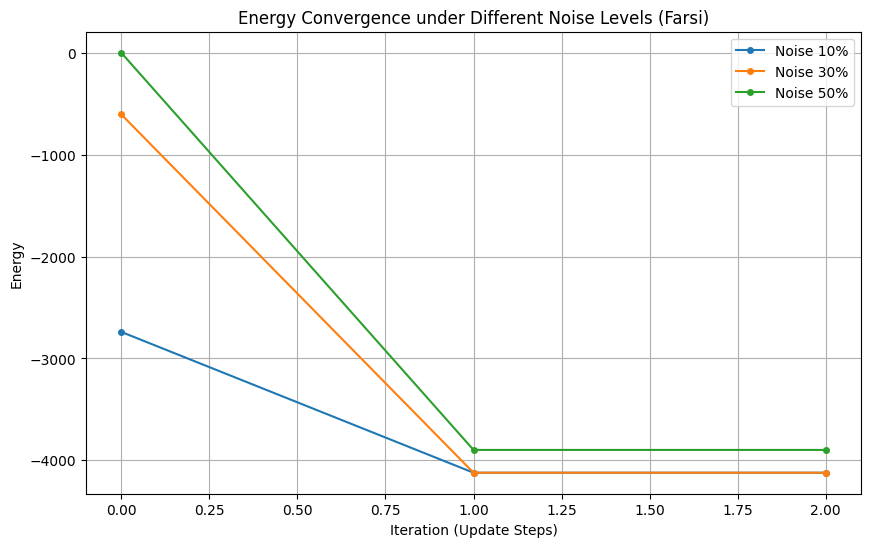

Energy plot saved to: results/Section2_Noise_Energy_Farsi.png

=== Running Section 2: Noise Analysis for English (First 3 patterns) ===
Noise Level     | Accuracy   | Converged?
---------------------------------------------
10%             | 100.0%    | Yes
30%             | 100.0%    | Yes
50%             |   0.0%    | Yes


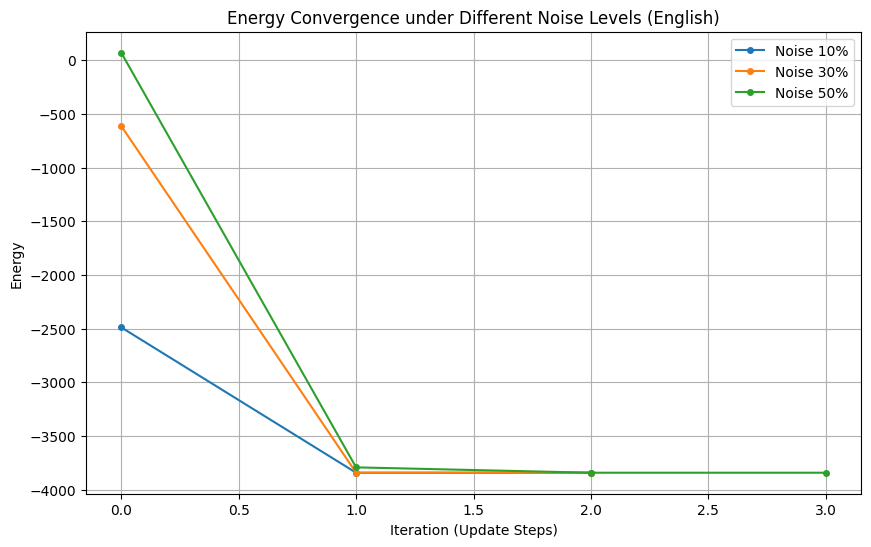

Energy plot saved to: results/Section2_Noise_Energy_English.png


In [47]:
def run_section2_noise_experiment(patterns, dataset_name, k_patterns=3):
    print(f"\n=== Running Section 2: Noise Analysis for {dataset_name} (First {k_patterns} patterns) ===")

    subset = patterns[:k_patterns]
    W = create_weight_matrix(subset)

    noise_levels = [0.10, 0.30, 0.50]

    plt.figure(figsize=(10, 6))

    target_idx = 0
    target_pattern = subset[target_idx]

    print(f"{'Noise Level':<15} | {'Accuracy':<10} | {'Converged?':<10}")
    print("-" * 45)

    for noise in noise_levels:
        correct_count = 0
        for i in range(k_patterns):
            noisy_p = add_noise(subset[i], noise_level=noise)
            # Using Asynchronous for smoother energy plots
            recovered, _ = asynchronous_recall_with_energy(noisy_p, W)
            if np.array_equal(recovered, subset[i]):
                correct_count += 1

        accuracy = (correct_count / k_patterns) * 100

        noisy_sample = add_noise(target_pattern, noise_level=noise)
        _, energies = asynchronous_recall_with_energy(noisy_sample, W)

        converged = "Yes" if len(energies) > 1 and energies[-1] <= energies[-2] else "No"

        print(f"{int(noise*100)}%             | {accuracy:5.1f}%    | {converged}")

        plt.plot(energies, marker='o', markersize=4, label=f'Noise {int(noise*100)}%')

    plt.title(f'Energy Convergence under Different Noise Levels ({dataset_name})')
    plt.xlabel('Iteration (Update Steps)')
    plt.ylabel('Energy')
    plt.legend()
    plt.grid(True)

    # Save the plot
    save_path = RESULTS_DIR / f"Section2_Noise_Energy_{dataset_name}.png"
    plt.savefig(save_path)
    plt.show()
    print(f"Energy plot saved to: {save_path}")

run_section2_noise_experiment(farsi_patterns, 'Farsi', k_patterns=3)

run_section2_noise_experiment(english_patterns, 'English', k_patterns=3)